# Project: Identify Customer Segments - Brenner Swenson
***


In [231]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import time

# magic word for producing visualizations in notebook
%matplotlib inline
from IPython.core.display import HTML
from jupyterthemes import jtplot
jtplot.style('grade3')
%config InlineBackend.figure_format = 'retina'

### Step 0: Load the Data



In [232]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [233]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Population raw data shape: {}'.format(azdias.shape))

Population raw data shape: (891221, 85)


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs

In [234]:
# create copies of data for later comparison
data_raw = azdias.copy()
features_raw = feat_info.copy()

In [235]:
# helper function
def process_x(string):
    pre_result = string.strip('[]').split(
        ',')  # removes brackets and creates list of elements
    pre_result = list(map(lambda x: x.strip(),
                          pre_result))  # removes whitespace
    result = list(
        map(lambda x: int(x) if x.strip('-').isdigit() else x,
            pre_result))  # converts numbers from str to num
    if result == ['']:
        result = string
        return result
    else:
        return result

In [236]:
# convert missing codes from strings to lists
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(
    process_x)

In [237]:
# Identify missing or unknown data values and convert them to NaNs.

for i in range(len(feat_info)):  # iterate through all columns
    unknown_list = feat_info['missing_or_unknown'].iloc[i]
    if len(unknown_list) == 0:
        pass  # skips values that have already been converted to NaNs

    for x in range(len(feat_info['missing_or_unknown'].iloc[i])):
        # iterate through missing/unknown list
        # iterate through missing values for each column, if matches, replace with np.nan
        (azdias[feat_info['attribute'][i]].replace(
            unknown_list, np.nan, inplace=True))

In [238]:
# compares cleaned data with raw data
print('NaN ENCODED DATA')
print('*' * 50)
print(azdias['ALTERSKATEGORIE_GROB'].unique())
print(azdias['CAMEO_INTL_2015'].unique())

NaN ENCODED DATA
**************************************************
[ 2.  1.  3.  4. nan]
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


In [239]:
print('RAW ENCODED DATA')
print('*' * 50)
print(data_raw['ALTERSKATEGORIE_GROB'].unique())
print(data_raw['CAMEO_INTL_2015'].unique())

RAW ENCODED DATA
**************************************************
[2 1 3 4 9]
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


#### Step 1.1.2: Assess Missing Data in Each Column

In [240]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing = pd.DataFrame(azdias.isnull().sum())  # sum of missing data
missing.columns = ['sum NaN']  # new column title
# create new column with % of column is NaN
missing['% NaN'] = ((missing['sum NaN'] / len(azdias)) * 100)
# sort descending
missing.sort_values('% NaN', ascending=False, inplace=True)
# merge with feat_info DF to look at data type info level trends
missing = pd.merge(
    missing,
    feat_info[['information_level', 'type']],
    left_on=missing.index,
    right_on=feat_info['attribute'])
missing.set_index('key_0', inplace=True, drop=True)

# EASIER THAN HISTOGRAM TO DETERMINE OUTLIERS

print('% NaN BY COLUMN')
display(missing.head(10))

% NaN BY COLUMN


sum NaN      % NaN information_level         type
key_0                                                            
TITEL_KZ         889061  99.757636            person  categorical
AGER_TYP         685843  76.955435            person  categorical
KK_KUNDENTYP     584612  65.596749         household  categorical
KBA05_BAUMAX     476524  53.468668     microcell_rr3        mixed
GEBURTSJAHR      392318  44.020282            person      numeric
ALTER_HH         310267  34.813699         household     interval
KKK              158064  17.735668        region_rr1      ordinal
REGIOTYP         158064  17.735668        region_rr1      ordinal
W_KEIT_KIND_HH   147988  16.605084         household      ordinal
KBA05_ANTG1      133324  14.959701     microcell_rr3      ordinal

In [241]:
# look at all rows without hiding middle rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(missing.sort_values('key_0'))

sum NaN      % NaN information_level         type
key_0                                                                   
AGER_TYP                685843  76.955435            person  categorical
ALTERSKATEGORIE_GROB      2881   0.323264            person      ordinal
ALTER_HH                310267  34.813699         household     interval
ANREDE_KZ                    0   0.000000            person  categorical
ANZ_HAUSHALTE_AKTIV      99611  11.176913          building      numeric
ANZ_HH_TITEL             97008  10.884842          building      numeric
ANZ_PERSONEN             73499   8.247000         household      numeric
ANZ_TITEL                73499   8.247000         household      numeric
ARBEIT                   97375  10.926022         community      ordinal
BALLRAUM                 93740  10.518154          postcode      ordinal
CAMEO_DEUG_2015          99352  11.147852     microcell_rr4  categorical
CAMEO_DEU_2015           99352  11.147852     microcell_rr4  categorical
CAMEO_INTL_2015          99352  11.147852     microcell_rr4        mixed
CJT_GESAMTTYP             4854   0.544646            person  categorical
EWDICHTE                 93740  10.518154          postcode      ordinal
FINANZTYP                    0   0.000000            person  categorical
FINANZ_ANLEGER               0   0.000000            person      ordinal
FINANZ_HAUSBAUER             0   0.000000            person      ordinal
FINANZ_MINIMALIST            0   0.000000            person      ordinal
FINANZ_SPARER                0   0.000000            person      ordinal
FINANZ_UNAUFFAELLIGER        0   0.000000            person      ordinal
FINANZ_VORSORGER             0   0.000000            person      ordinal
GEBAEUDETYP              93148  10.451729          building  categorical
GEBAEUDETYP_RASTER       93155  10.452514        region_rr1      ordinal
GEBURTSJAHR             392318  44.020282            person      numeric
GFK_URLAUBERTYP           4854   0.544646            person  categorical
GREEN_AVANTGARDE             0   0.000000            person  categorical
HEALTH_TYP              111196  12.476816            person      ordinal
HH_EINKOMMEN_SCORE       18348   2.058749         household      ordinal
INNENSTADT               93740  10.518154          postcode      ordinal
KBA05_ANTG1             133324  14.959701     microcell_rr3      ordinal
KBA05_ANTG2             133324  14.959701     microcell_rr3      ordinal
KBA05_ANTG3             133324  14.959701     microcell_rr3      ordinal
KBA05_ANTG4             133324  14.959701     microcell_rr3      ordinal
KBA05_BAUMAX            476524  53.468668     microcell_rr3        mixed
KBA05_GBZ               133324  14.959701     microcell_rr3      ordinal
KBA13_ANZAHL_PKW        105800  11.871354    macrocell_plz8      numeric
KKK                     158064  17.735668        region_rr1      ordinal
KK_KUNDENTYP            584612  65.596749         household  categorical
KONSUMNAEHE              73969   8.299737          building      ordinal
LP_FAMILIE_FEIN          77792   8.728699            person  categorical
LP_FAMILIE_GROB          77792   8.728699            person  categorical
LP_LEBENSPHASE_FEIN      97632  10.954859            person        mixed
LP_LEBENSPHASE_GROB      94572  10.611509            person        mixed
LP_STATUS_FEIN            4854   0.544646            person  categorical
LP_STATUS_GROB            4854   0.544646            person  categorical
MIN_GEBAEUDEJAHR         93148  10.451729          building      numeric
MOBI_REGIO              133324  14.959701        region_rr1      ordinal
NATIONALITAET_KZ        108315  12.153551            person  categorical
ONLINE_AFFINITAET         4854   0.544646        region_rr1      ordinal
ORTSGR_KLS9              97274  10.914689         community      ordinal
OST_WEST_KZ              93148  10.451729          building  categorical
PLZ8_ANTG1              116515  13.073637    macrocell_plz8      ordinal
PLZ8_ANT

In [242]:
# Investigate patterns in the amount of missing data in each column.

# correlation matrix of % NaN and information_level
info_level_corr = missing.information_level.str.get_dummies().corrwith(
    missing['% NaN']).sort_values(ascending=False)

print('INFO LEVEL CORRELATION', '\n')
print('*' * 30)
print(info_level_corr, '\n')

# correlation matrix of % NaN and data type
data_type_corr = missing.type.str.get_dummies().corrwith(
    missing['% NaN']).sort_values(ascending=False)

print('DATA TYPE CORRELATION', '\n')
print('*' * 30)
print(data_type_corr)

INFO LEVEL CORRELATION 

******************************
microcell_rr3     0.173983
household         0.173867
macrocell_plz8    0.036844
region_rr1        0.018827
microcell_rr4     0.001096
community        -0.001543
postcode         -0.006269
building         -0.013636
person           -0.205134
dtype: float64 

DATA TYPE CORRELATION 

******************************
categorical    0.197434
interval       0.158529
mixed          0.116370
numeric        0.072022
ordinal       -0.311740
dtype: float64


In [243]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# remove 6 top features with highest NaN percentages
azdias.drop(missing.index[:6], axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

#### There are six columns where the proportion of missing data is much larger than the other 79 columns. Those columns are: 
`TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, `ALTER_HH`
    
***

#### I removed these columns from the dataset as there was a significant drop off after 'ALTER_HH' in terms of % NaN. In the above two cells I created two corrwith() matrices that illustrate how the columns' data type and information_level attributes relate to the amount of data that is missing from the feature. As the matrices suggest, categorical data tends to have more missing data, whereas ordinal data is inversely correlated.

#### If you look at the features themselves, many of them are in groups, like the "CAMEO" features, for example, which are life stage typologies in rough, and detailed scales; so, they have the same amount of missing data as they are reporting the same data. 

#### Step 1.1.3: Assess Missing Data in Each Row

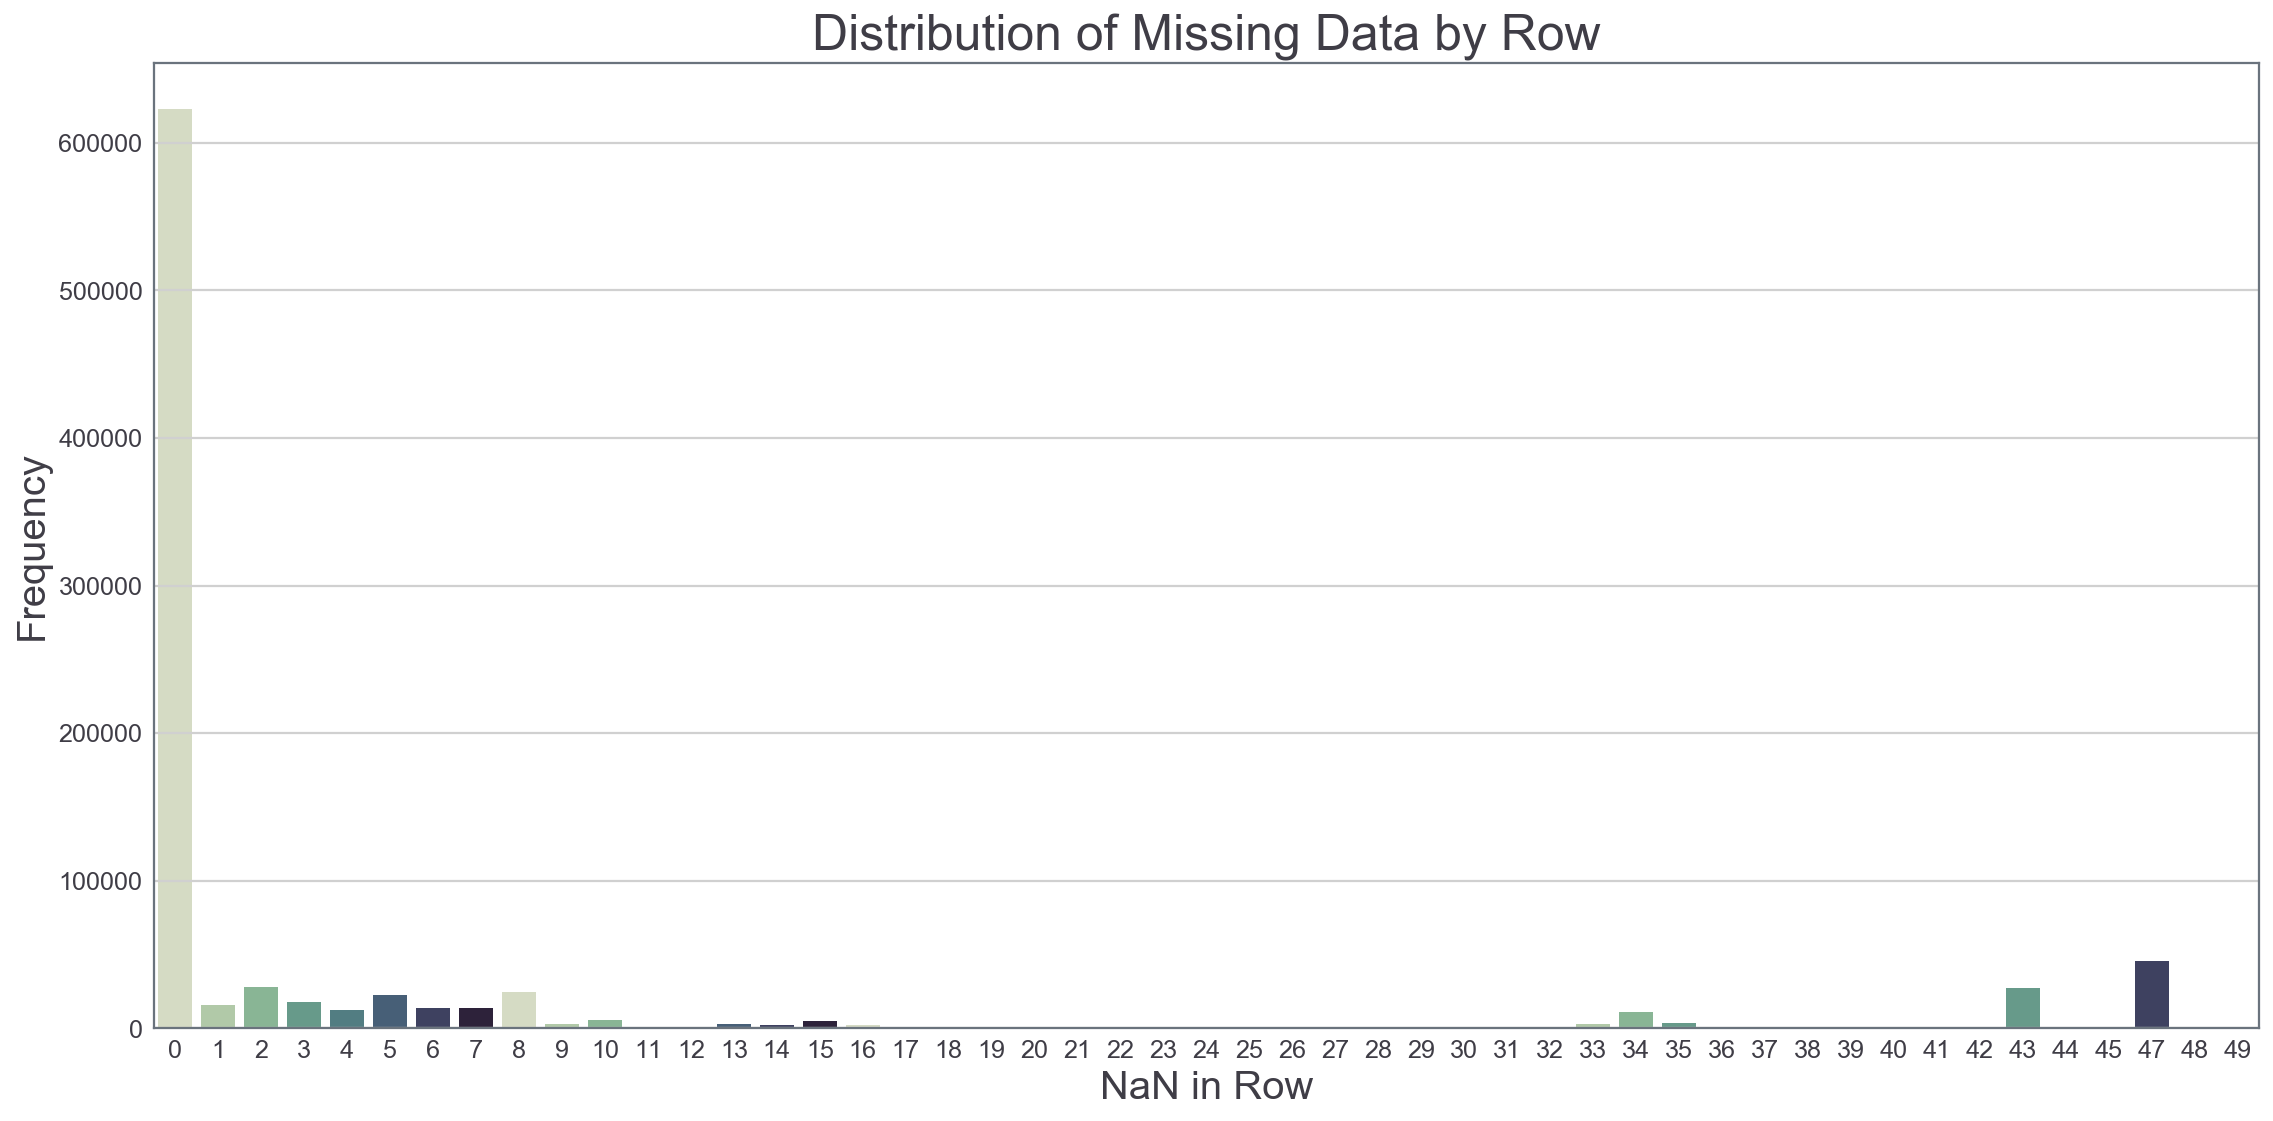

In [244]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(
    azdias.isnull().sum(axis=1).sort_values(ascending=False),
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
ax.set_xlabel('NaN in Row', fontdict={'fontsize': 20})
ax.set_ylabel('Frequency', fontdict={'fontsize': 20})
ax.set_title('Distribution of Missing Data by Row', fontdict={'fontsize': 25})
fig.tight_layout()

In [245]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# add a column to DF with sum of NaN values in row
azdias['row NaN'] = azdias.isnull().sum(axis=1)

# create subset of data where sum of NaNs per row is less than or equal to 10
fewer_ten_perc_NaN = azdias.loc[azdias['row NaN'] <= 10]

# create subset of data where sum of NaNs per row is greater than 10
more_ten_perc_NaN = azdias.loc[azdias['row NaN'] > 10]

In [246]:
print('Shape of DF with less than 10 NaNs per row: {}'.format(
    fewer_ten_perc_NaN.shape))
# % of original data
print('{:.2%} of original data'.format(
    fewer_ten_perc_NaN.shape[0] / len(azdias)))

print('*' * 75)

print('Shape of DF with more than 10 NaNs per row: {}'.format(
    more_ten_perc_NaN.shape))
# % of original data
print('{:.2%} of original data'.format(
    more_ten_perc_NaN.shape[0] / len(azdias)))

print('*' * 75)

# make sure that sum of subsets' lengths equals sum of original data
print(
    'Length of two data frames added together equals len of original data? \n{}'.
    format((len(fewer_ten_perc_NaN) + len(more_ten_perc_NaN)) == len(azdias)))

Shape of DF with less than 10 NaNs per row: (780153, 80)
87.54% of original data
***************************************************************************
Shape of DF with more than 10 NaNs per row: (111068, 80)
12.46% of original data
***************************************************************************
Length of two data frames added together equals len of original data? 
True


In [247]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


def col_compare(less_NaN_df, more_NaN_df, col):
    '''
    INPUT:
        less_NaN_df: DataFrame with exactly same columns as other DF
        more_NaN_df: DataFrame with exactly same columns as other DF
        col: str of column label wished to be compared
    OUTPUT:
        Two plots
    '''
    f, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(8, 3))  # create two axes next to each other
    f.dpi = 85  # set resolution
    ax1.set_title('<= 10% NaN')  # title 1
    ax2.set_title('> 10% NaN')  # title 2
    # first plot
    sns.countplot(
        x=col,
        data=less_NaN_df,
        ax=ax1,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
    # second plot
    sns.countplot(
        x=col,
        data=more_NaN_df,
        ax=ax2,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
    f.tight_layout()

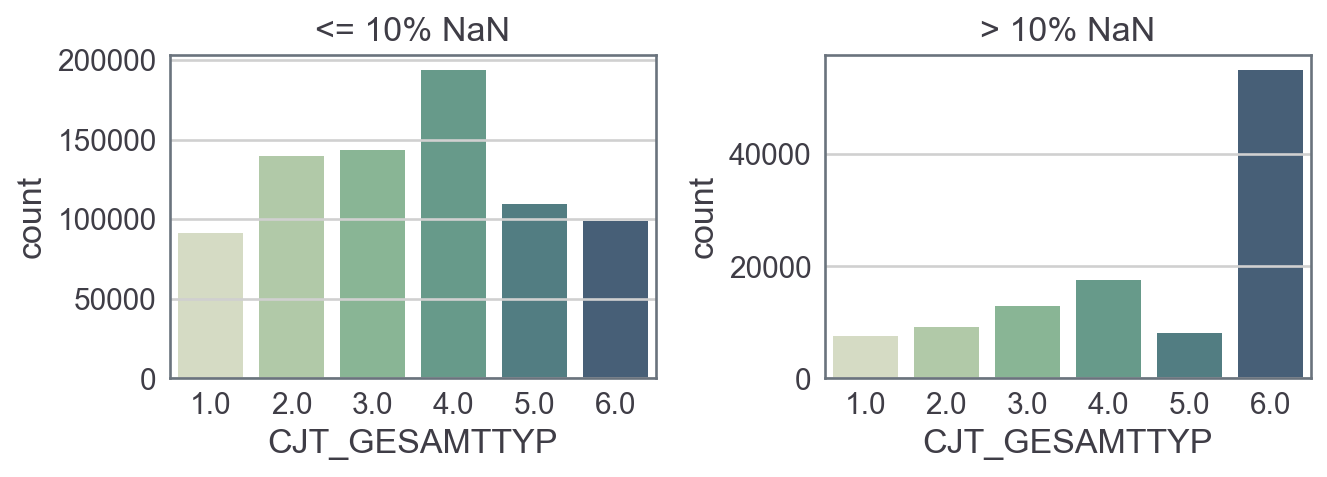

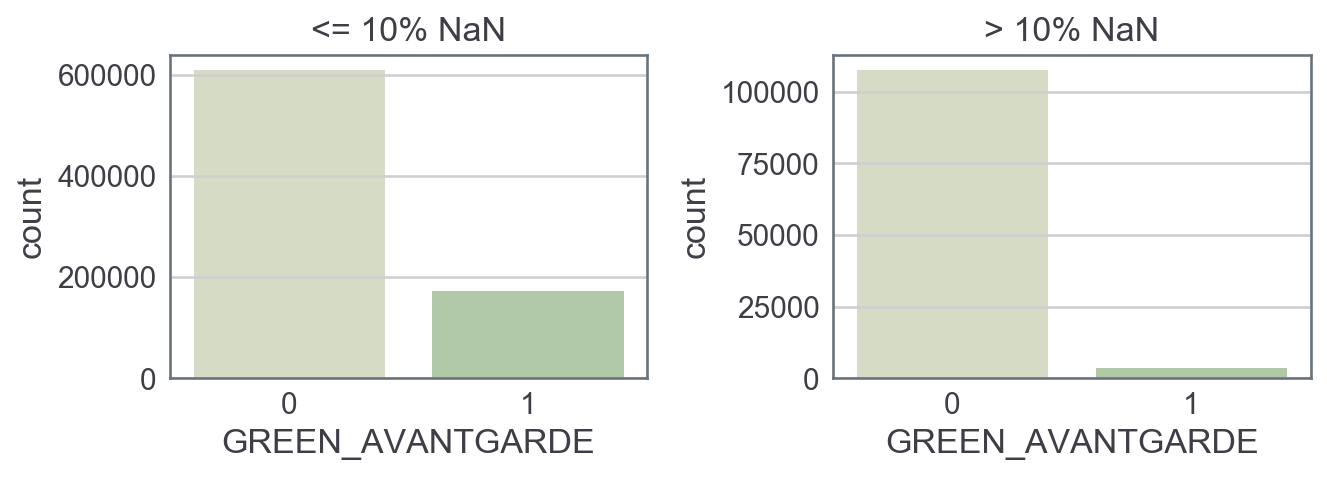

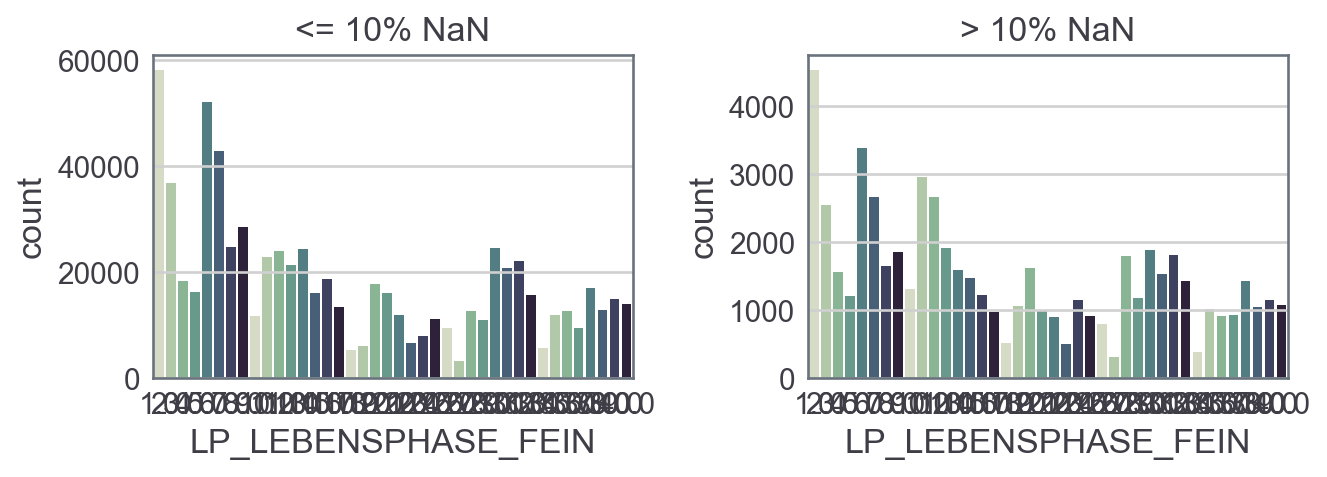

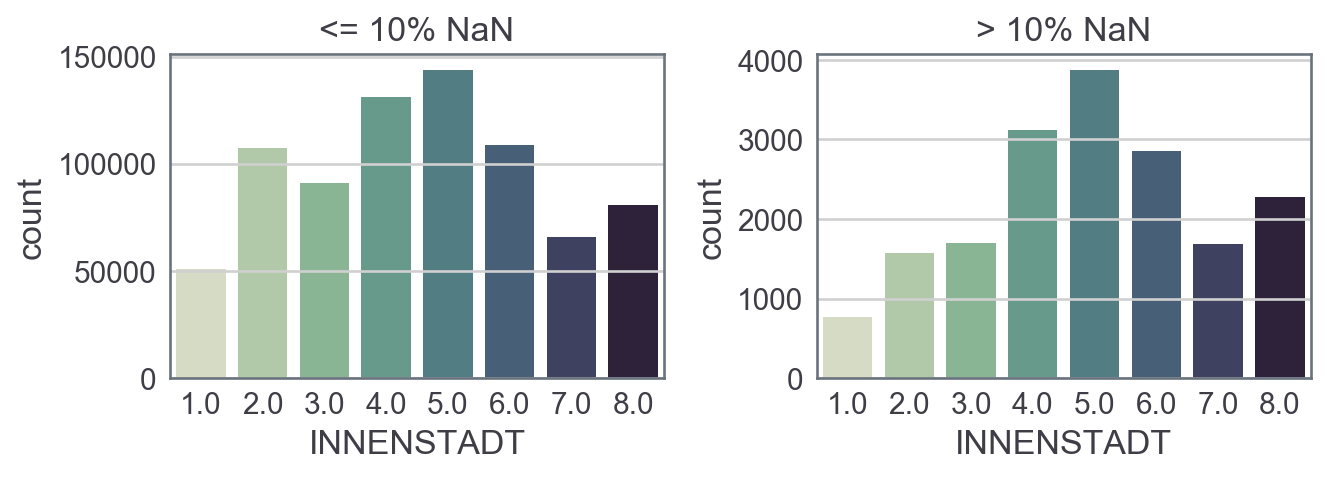

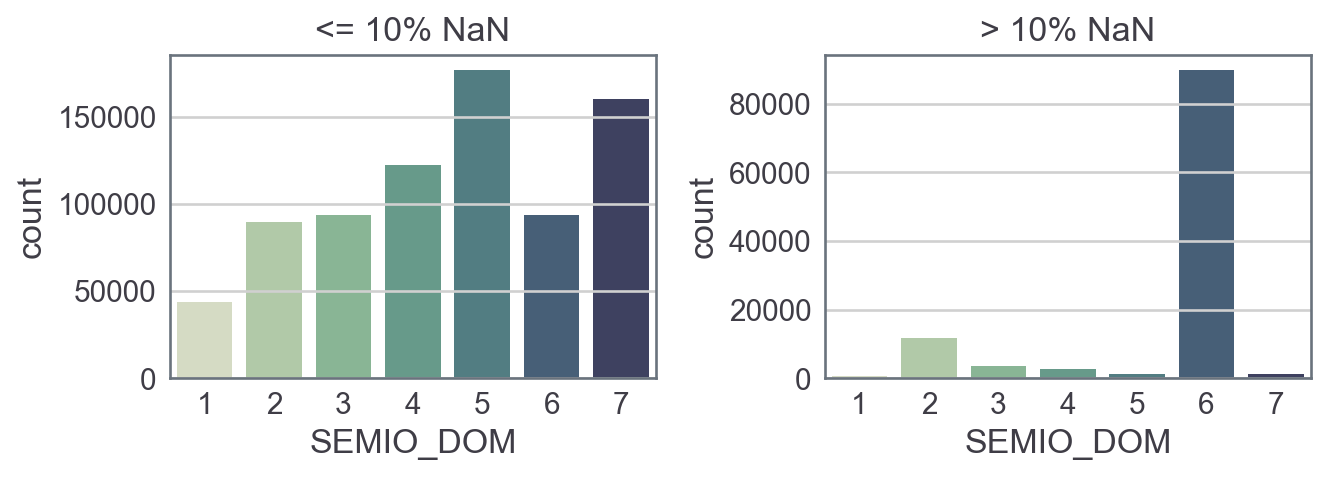

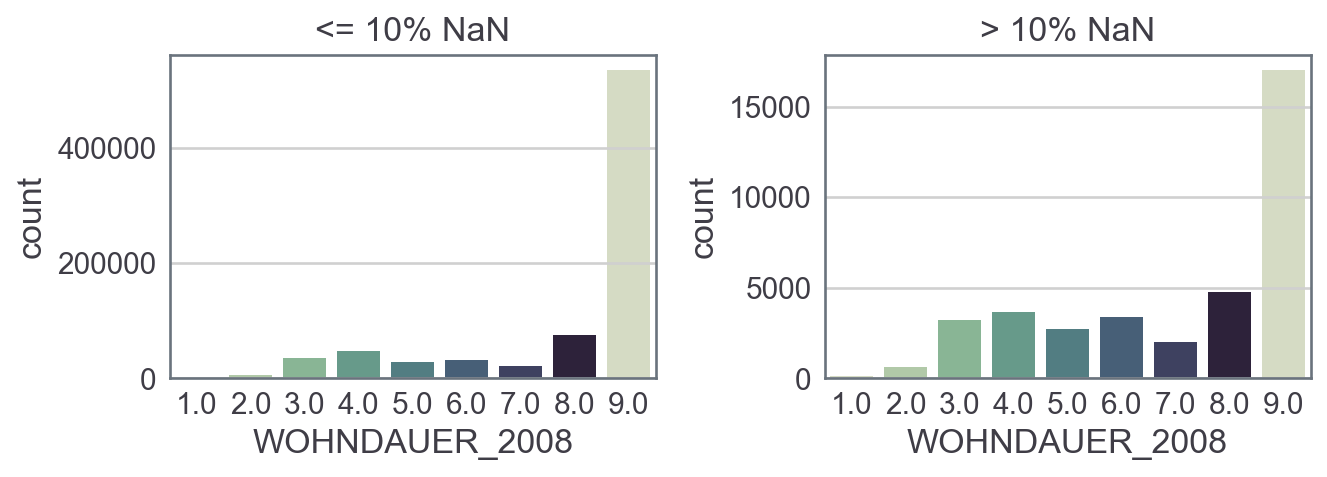

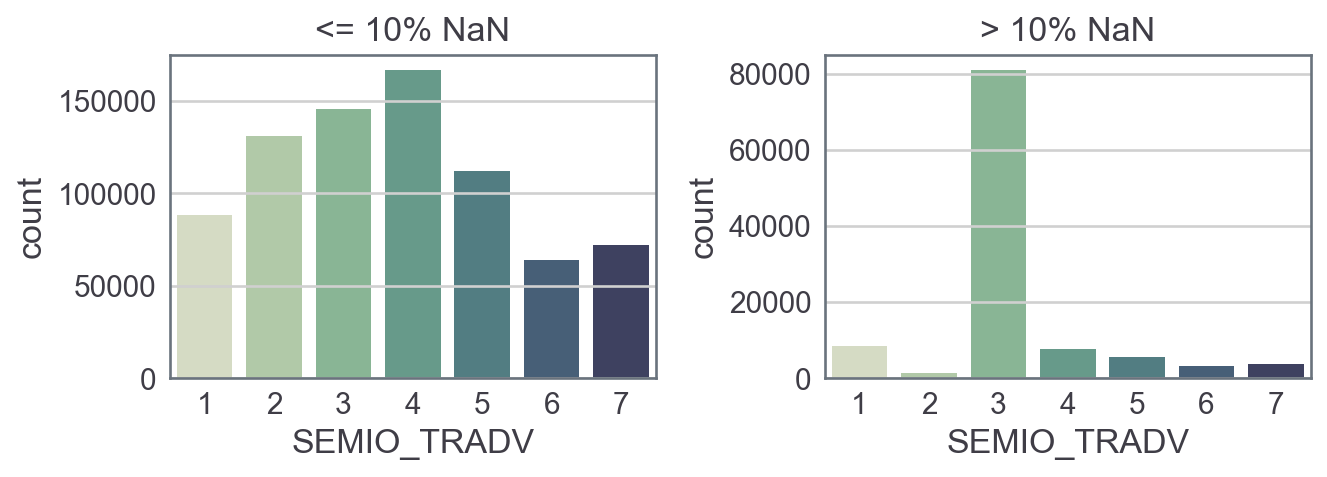

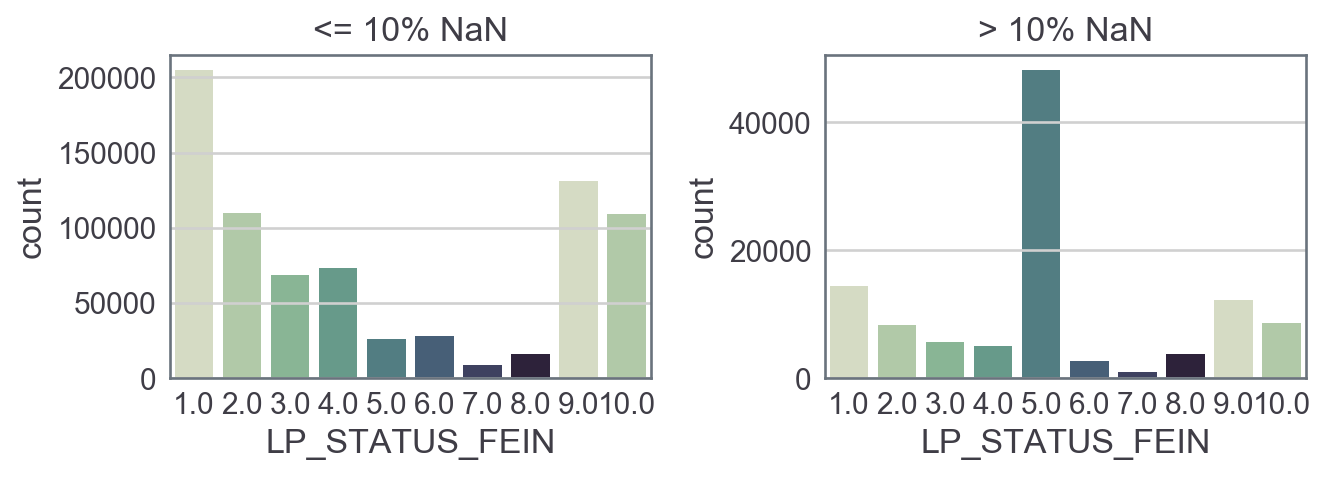

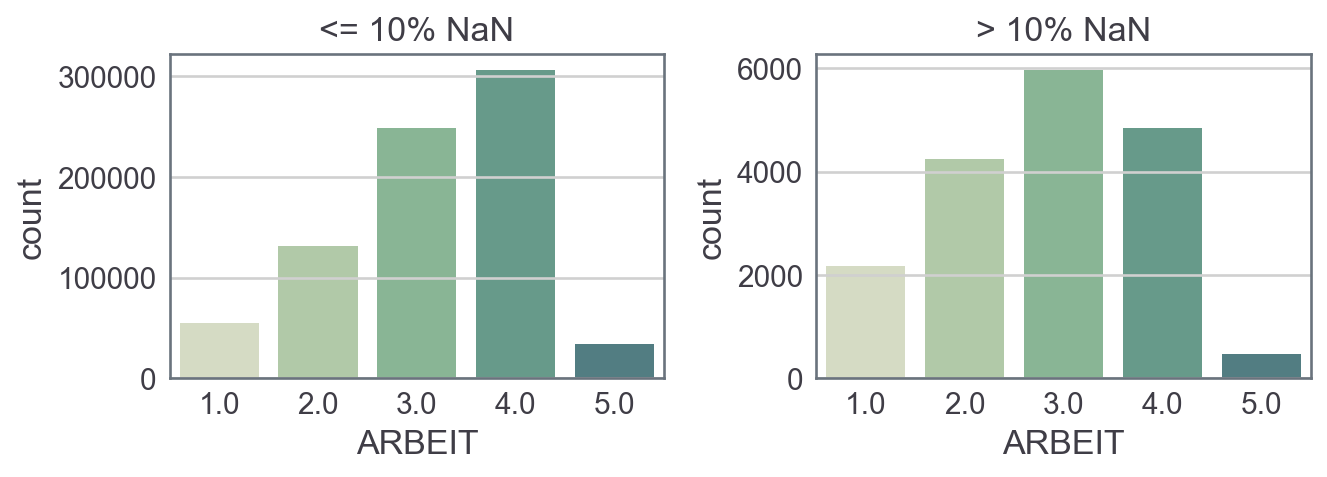

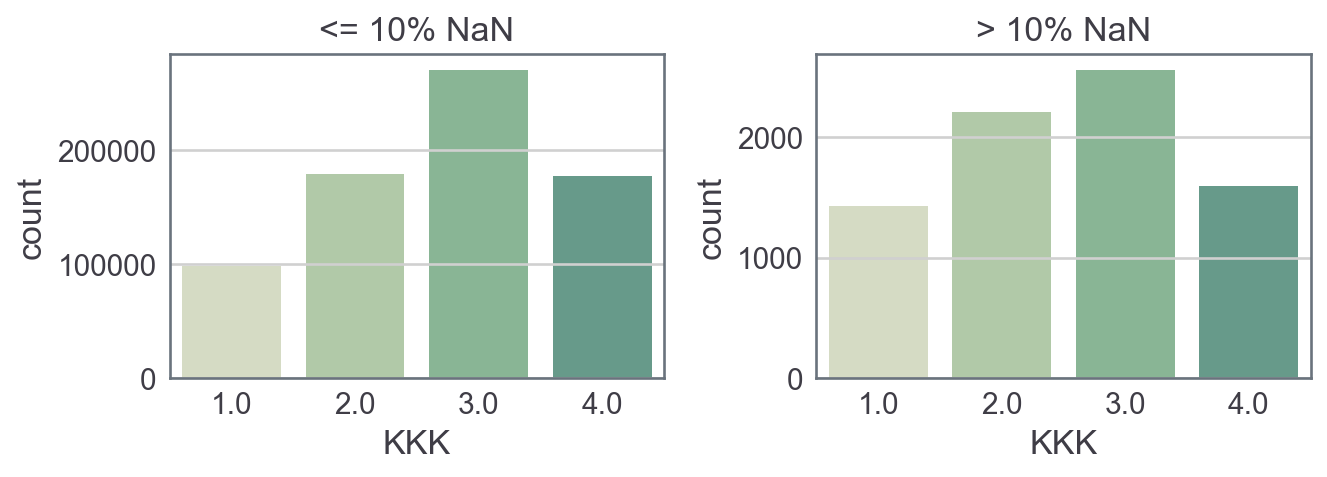

In [248]:
# random columns
rand_columns = azdias.columns.to_series().sample(10)

# plot a bunch (10) of data distributions between two subsets
for i in range(len(rand_columns)):
    col_compare(fewer_ten_perc_NaN, more_ten_perc_NaN, rand_columns[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row
Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

#### Yes, some of the columns are significantly different in how the data is distributed. The data with more than 10 NaNs per row should be excluded from analysis. This exclusion is okay as this subset only represents 12.46% of the data points and is relatively immaterial.

***

### Step 1.2: Select and Re-Encode Features

In [249]:
# How many features are there of each data type?

# count of data types
print('VALUE COUNTS OF DATA TYPES')
print('*' * 30)
display(
    pd.DataFrame(
        missing.groupby('type').count()['information_level'].sort_values(
            ascending=False)))

VALUE COUNTS OF DATA TYPES
******************************


information_level
type                          
ordinal                     49
categorical                 21
numeric                      7
mixed                        7
interval                     1

#### Step 1.2.1: Re-Encode Categorical Features

In [250]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# create subset of missing dataframe for only columns with the data type of categorical
n_unique = fewer_ten_perc_NaN.nunique()
categorical = missing.loc[missing['type'] == 'categorical']

# merge n_unique df created above
categorical = pd.merge(
    categorical,
    n_unique.to_frame(),
    left_on=categorical.index,
    right_on=n_unique.index)

# rename merged column as it came from an unnamed series
categorical.rename(
    columns={
        0: 'n_unique',
    }, inplace=True)

# create new column based off of n_unique, showing binary/multi
categorical['sub_type'] = categorical['n_unique'].apply(
    lambda x: 'binary' if x <= 2 else 'multi')

# sort by sub_type
print('CATEGORICAL DATA SORTED BY SUB_TYPE')
display(categorical.sort_values('n_unique'))

CATEGORICAL DATA SORTED BY SUB_TYPE


key_0  sum NaN      % NaN information_level         type  \
0           VERS_TYP   111196  12.476816            person  categorical   
15  GREEN_AVANTGARDE        0   0.000000            person  categorical   
5        OST_WEST_KZ    93148  10.451729          building  categorical   
9            SOHO_KZ    73499   8.247000            person  categorical   
16         ANREDE_KZ        0   0.000000            person  categorical   
2   NATIONALITAET_KZ   108315  12.153551            person  categorical   
1        SHOPPER_TYP   111196  12.476816            person  categorical   
13    LP_STATUS_GROB     4854   0.544646            person  categorical   
8    LP_FAMILIE_GROB    77792   8.728699            person  categorical   
11     CJT_GESAMTTYP     4854   0.544646            person  categorical   
14         FINANZTYP        0   0.000000            person  categorical   
17          ZABEOTYP        0   0.000000            person  categorical   
6        GEBAEUDETYP    93148  10.451729          building  categorical   
4    CAMEO_DEUG_2015    99352  11.147852     microcell_rr4  categorical   
12    LP_STATUS_FEIN     4854   0.544646            person  categorical   
7    LP_FAMILIE_FEIN    77792   8.728699            person  categorical   
10   GFK_URLAUBERTYP     4854   0.544646            person  categorical   
3     CAMEO_DEU_2015    99352  11.147852     microcell_rr4  categorical   

    n_unique sub_type  
0          2   binary  
15         2   binary  
5          2   binary  
9          2   binary  
16         2   binary  
2          3    multi  
1          4    multi  
13         5    multi  
8          5    multi  
11         6    multi  
14         6    multi  
17         6    multi  
6          7    multi  
4          9    multi  
12        10    multi  
7         11    multi  
10        12    multi  
3         44    multi

In [251]:
print('DATA TYPES OF CATEGORICAL DATA')
display(fewer_ten_perc_NaN[categorical.key_0].dtypes)
print('Three columns are "objects" and need to be taken care of')

DATA TYPES OF CATEGORICAL DATA


VERS_TYP            float64
SHOPPER_TYP         float64
NATIONALITAET_KZ    float64
CAMEO_DEU_2015       object
CAMEO_DEUG_2015      object
OST_WEST_KZ          object
GEBAEUDETYP         float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
SOHO_KZ             float64
GFK_URLAUBERTYP     float64
CJT_GESAMTTYP       float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
FINANZTYP             int64
GREEN_AVANTGARDE      int64
ANREDE_KZ             int64
ZABEOTYP              int64
dtype: object

Three columns are "objects" and need to be taken care of


In [252]:
# Re-encode categorical variable(s) to be kept in the analysis.
cleaned = fewer_ten_perc_NaN.copy()

# re-encode the 'O' and 'W' values to binary representations
# also removes original column from analysis
cleaned['OST_WEST_KZ'] = cleaned['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
cleaned['OST_WEST_KZ'].unique()

array([1, 0])

In [253]:
# remove all multi categorical columns from analysis for ease of analysis
cleaned.drop(columns=categorical.loc[categorical['sub_type'] == 'multi'].key_0, inplace=True)

In [254]:
# now has 13 less columns
print('Before dropped columns:', fewer_ten_perc_NaN.shape)
print('After dropped columns:', cleaned.shape)

Before dropped columns: (780153, 80)
After dropped columns: (780153, 67)


#### Discussion 1.2.1: Re-Encode Categorical Features

#### OST_WEST_KZ was re-encoded to numerical binary values, as the data types were encoded as strings previously. The `CAMEO_DEU_2015` columns have too many potential dummy variables that would need to be created and it would be best to remove the columns from the analysis.


#### Step 1.2.2: Engineer Mixed-Type Features

In [255]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print('{:.2%} NaN BEFORE RE-ENGINEERING'.format(
    cleaned['PRAEGENDE_JUGENDJAHRE'].isnull().sum() / len(
        cleaned['PRAEGENDE_JUGENDJAHRE'])))

3.39% NaN BEFORE RE-ENGINEERING


MAJORITY OF VALUES ARE 14, WHICH ARE MAINSTREAM DIGITAL MEDIA KIDS


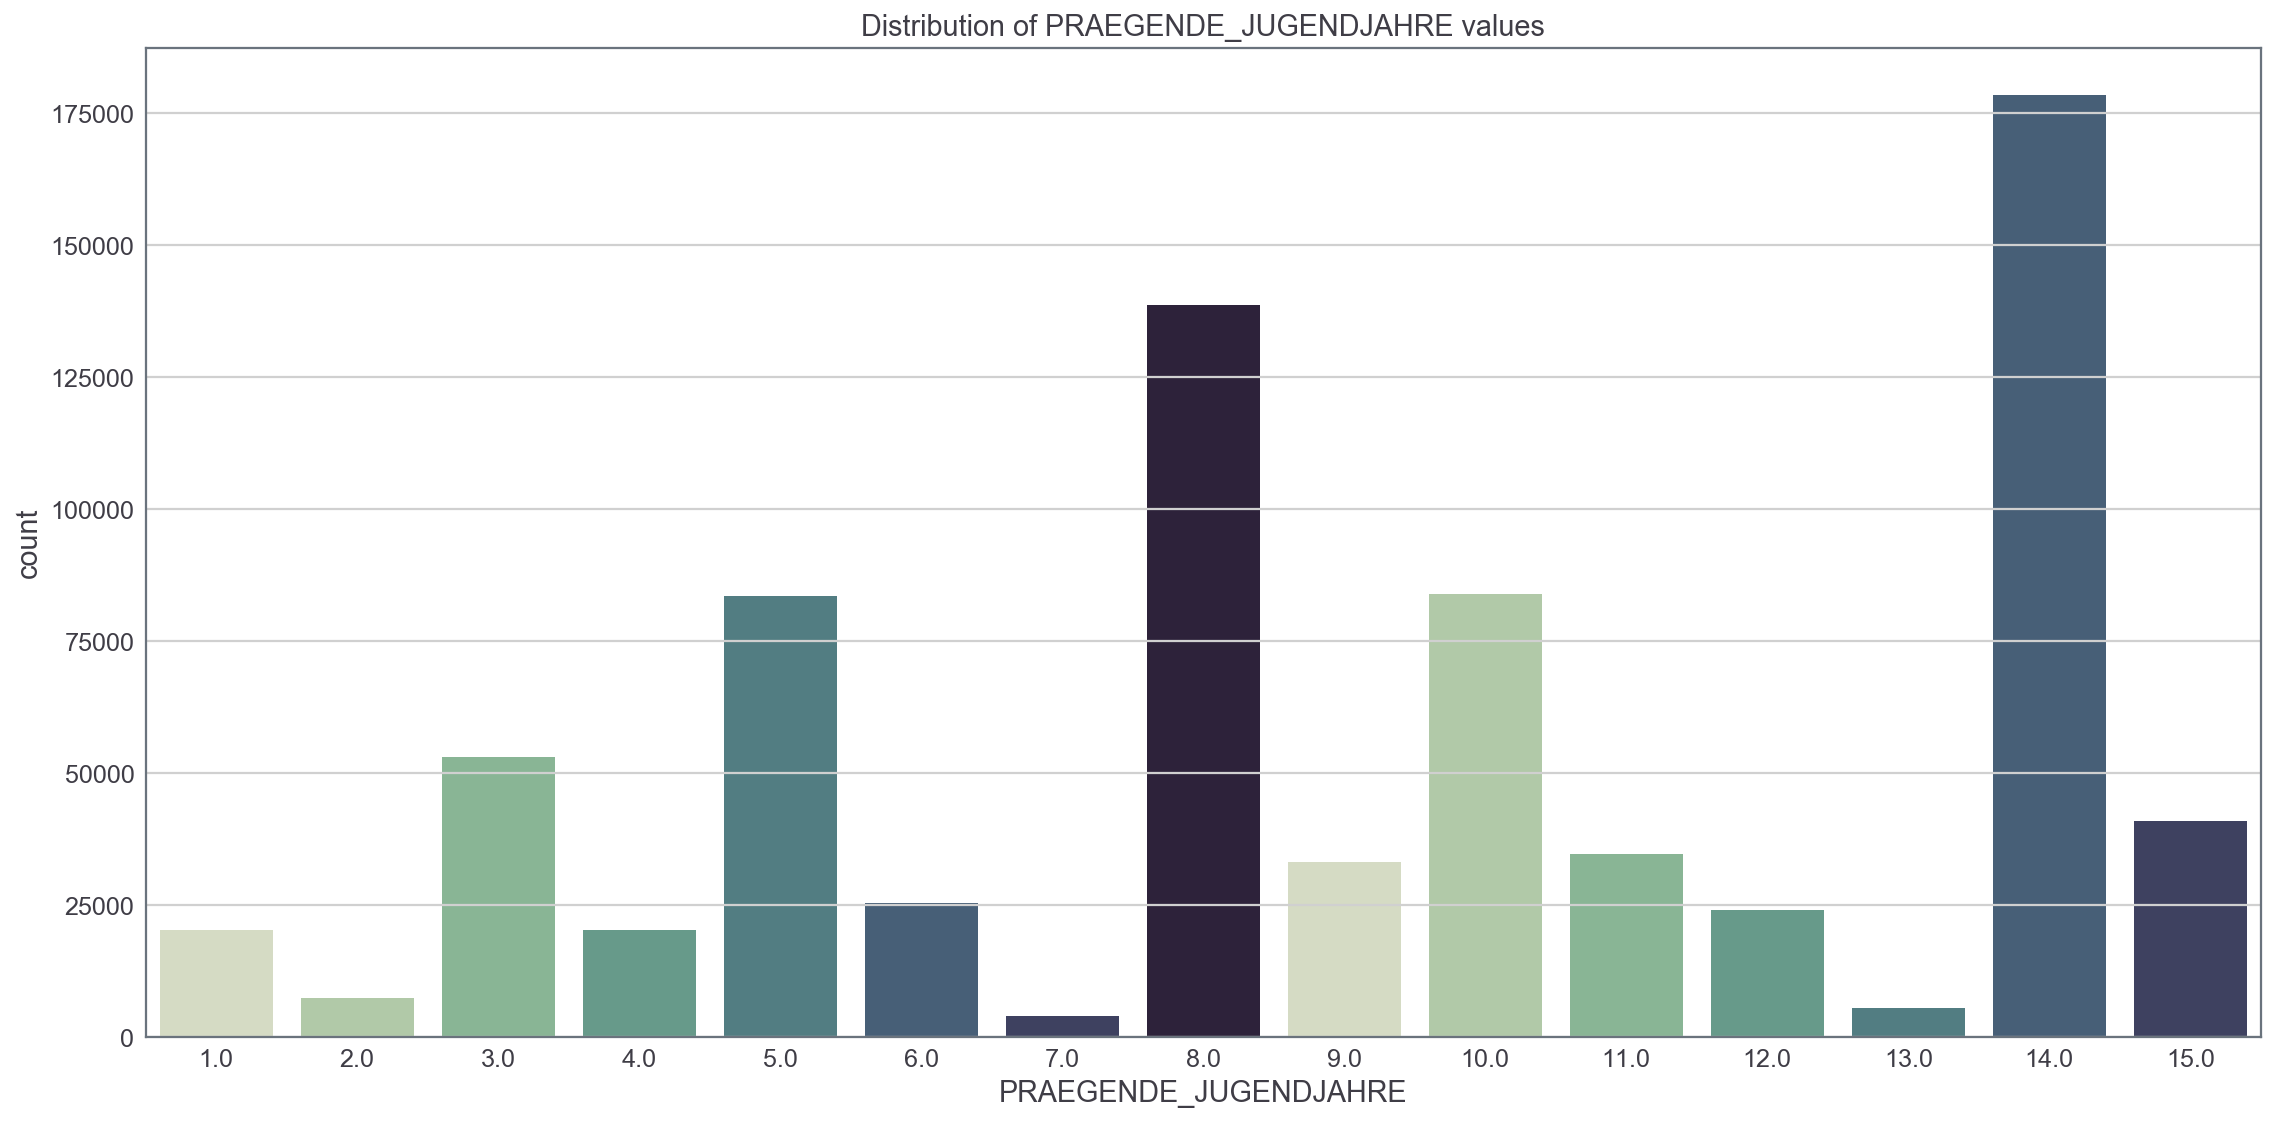

In [256]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Distribution of PRAEGENDE_JUGENDJAHRE values')
sns.countplot(
    data=cleaned,
    x='PRAEGENDE_JUGENDJAHRE',
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
fig.tight_layout()

print('MAJORITY OF VALUES ARE 14, WHICH ARE MAINSTREAM DIGITAL MEDIA KIDS')

#### According to the Data Dictionary, the majority of these data points are 90s digital media kids, closely followed by 70s - family orientation.

#### The data looks like this: 

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


#### So we will need to map values for decades and movements to new columns, extracting it from this column. We can do this by creating two dictionaries and mapping them to the new columns we create.

We will create values for decades like this:

- 1: 40's
- 2: 50's
- 3: 60's
- 4: 70's
- 5: 80's
- 6: 90's

And movement like this:
- 1: Mainstream
- 2: Avantgarde


In [257]:
# maps the existing decade codes to create 6 new variables
decades_map = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
    8: 4,
    9: 4,
    10: 5,
    11: 5,
    12: 5,
    13: 5,
    14: 6,
    15: 6
}
# maps the existing movement ints to create 2 new variables
movements_map = {
    1: 1,
    2: 2,
    3: 1,
    4: 2,
    5: 1,
    6: 2,
    7: 2,
    8: 1,
    9: 2,
    10: 1,
    11: 2,
    12: 1,
    13: 2,
    14: 1,
    15: 2
}

In [258]:
# apply and replace the old values with the mapped dictionaries above
cleaned['DECADE'] = cleaned.PRAEGENDE_JUGENDJAHRE.map(decades_map)
cleaned['MOVEMENT'] = cleaned.PRAEGENDE_JUGENDJAHRE.map(movements_map)

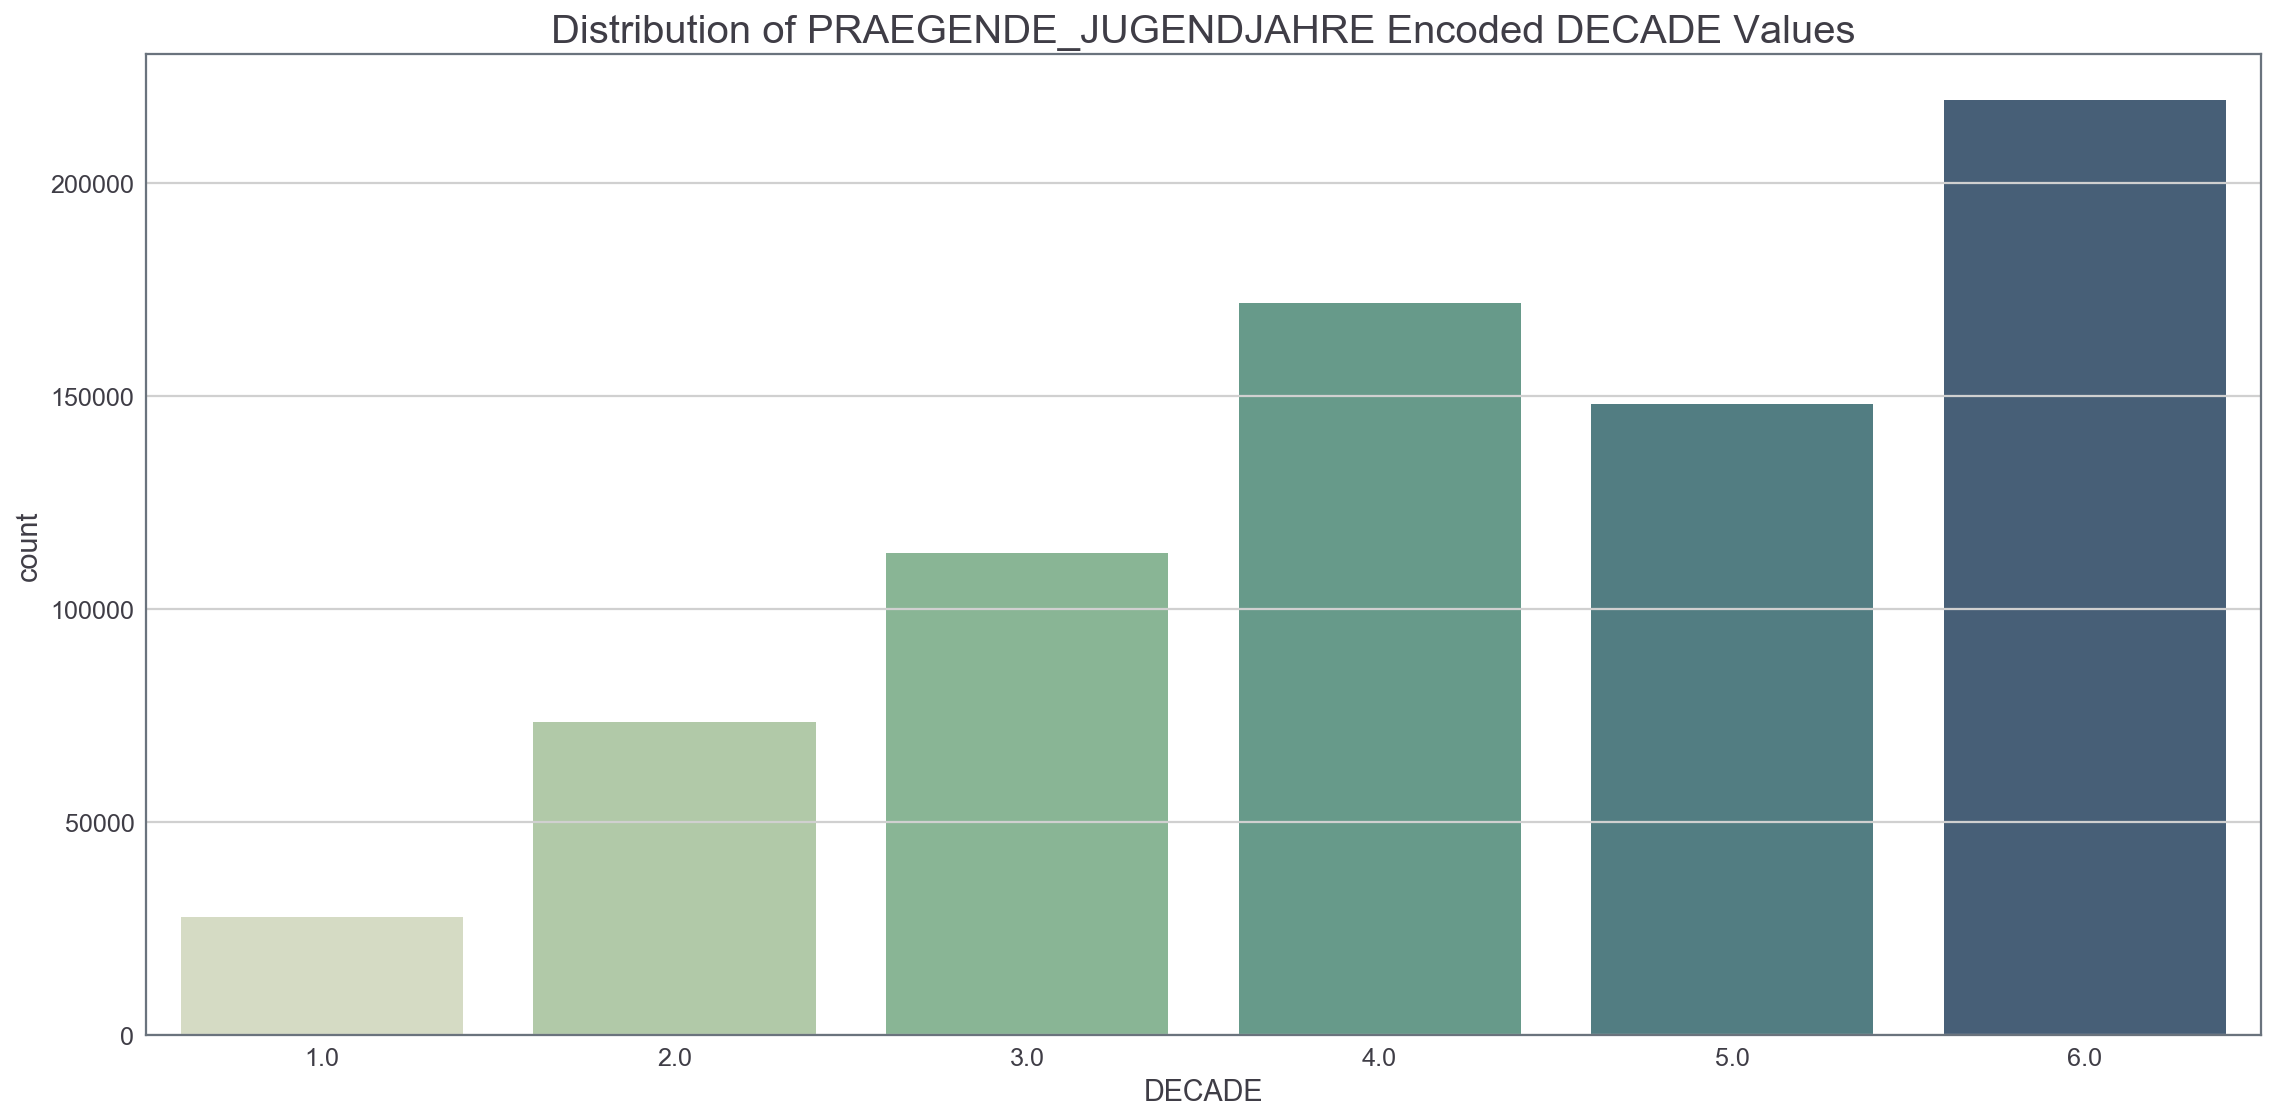

In [259]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title(
    'Distribution of PRAEGENDE_JUGENDJAHRE Encoded DECADE Values',
    fontdict={'fontsize': 20})
sns.countplot(
    data=cleaned,
    x='DECADE',
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
fig.tight_layout()

In [260]:
print('{:.2%} NaN DECADE AFTER RE-ENGINEERING'.format(
    cleaned['DECADE'].isnull().sum() / len(cleaned['DECADE'])))

# same as before, as to be expected

3.39% NaN DECADE AFTER RE-ENGINEERING


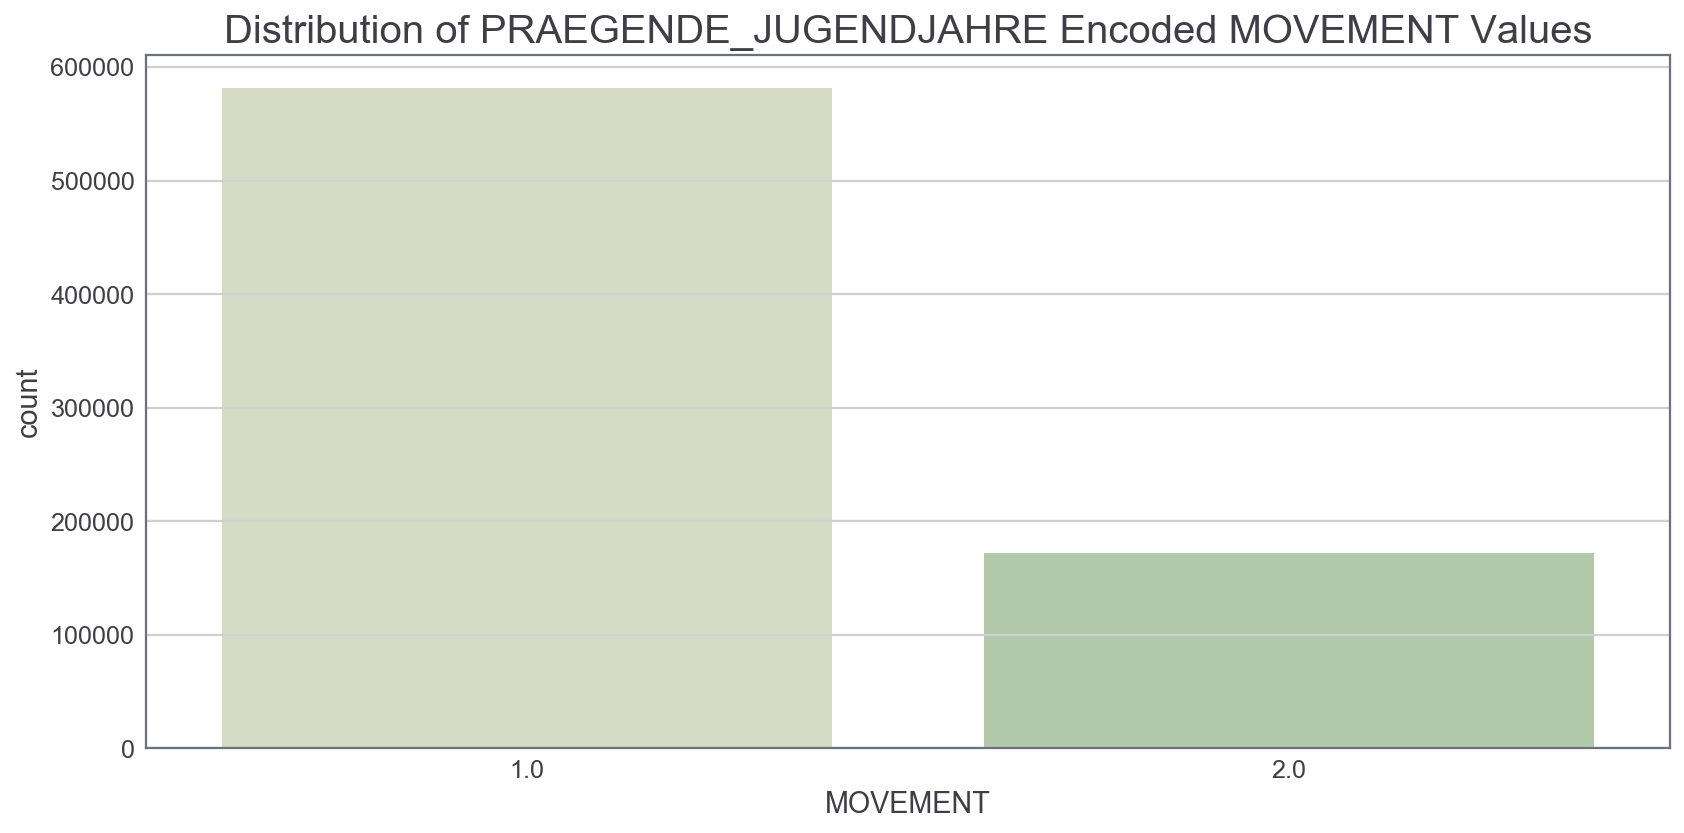

In [261]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(
    'Distribution of PRAEGENDE_JUGENDJAHRE Encoded MOVEMENT Values',
    fontdict={'fontsize': 20})
sns.countplot(
    data=cleaned,
    x='MOVEMENT',
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
fig.tight_layout()

In [262]:
print('{:.2%} NaN MOVEMENT AFTER RE-ENGINEERING'.format(
    cleaned['MOVEMENT'].isnull().sum() / len(cleaned['MOVEMENT'])))

# same as before, as to be expected

3.39% NaN MOVEMENT AFTER RE-ENGINEERING


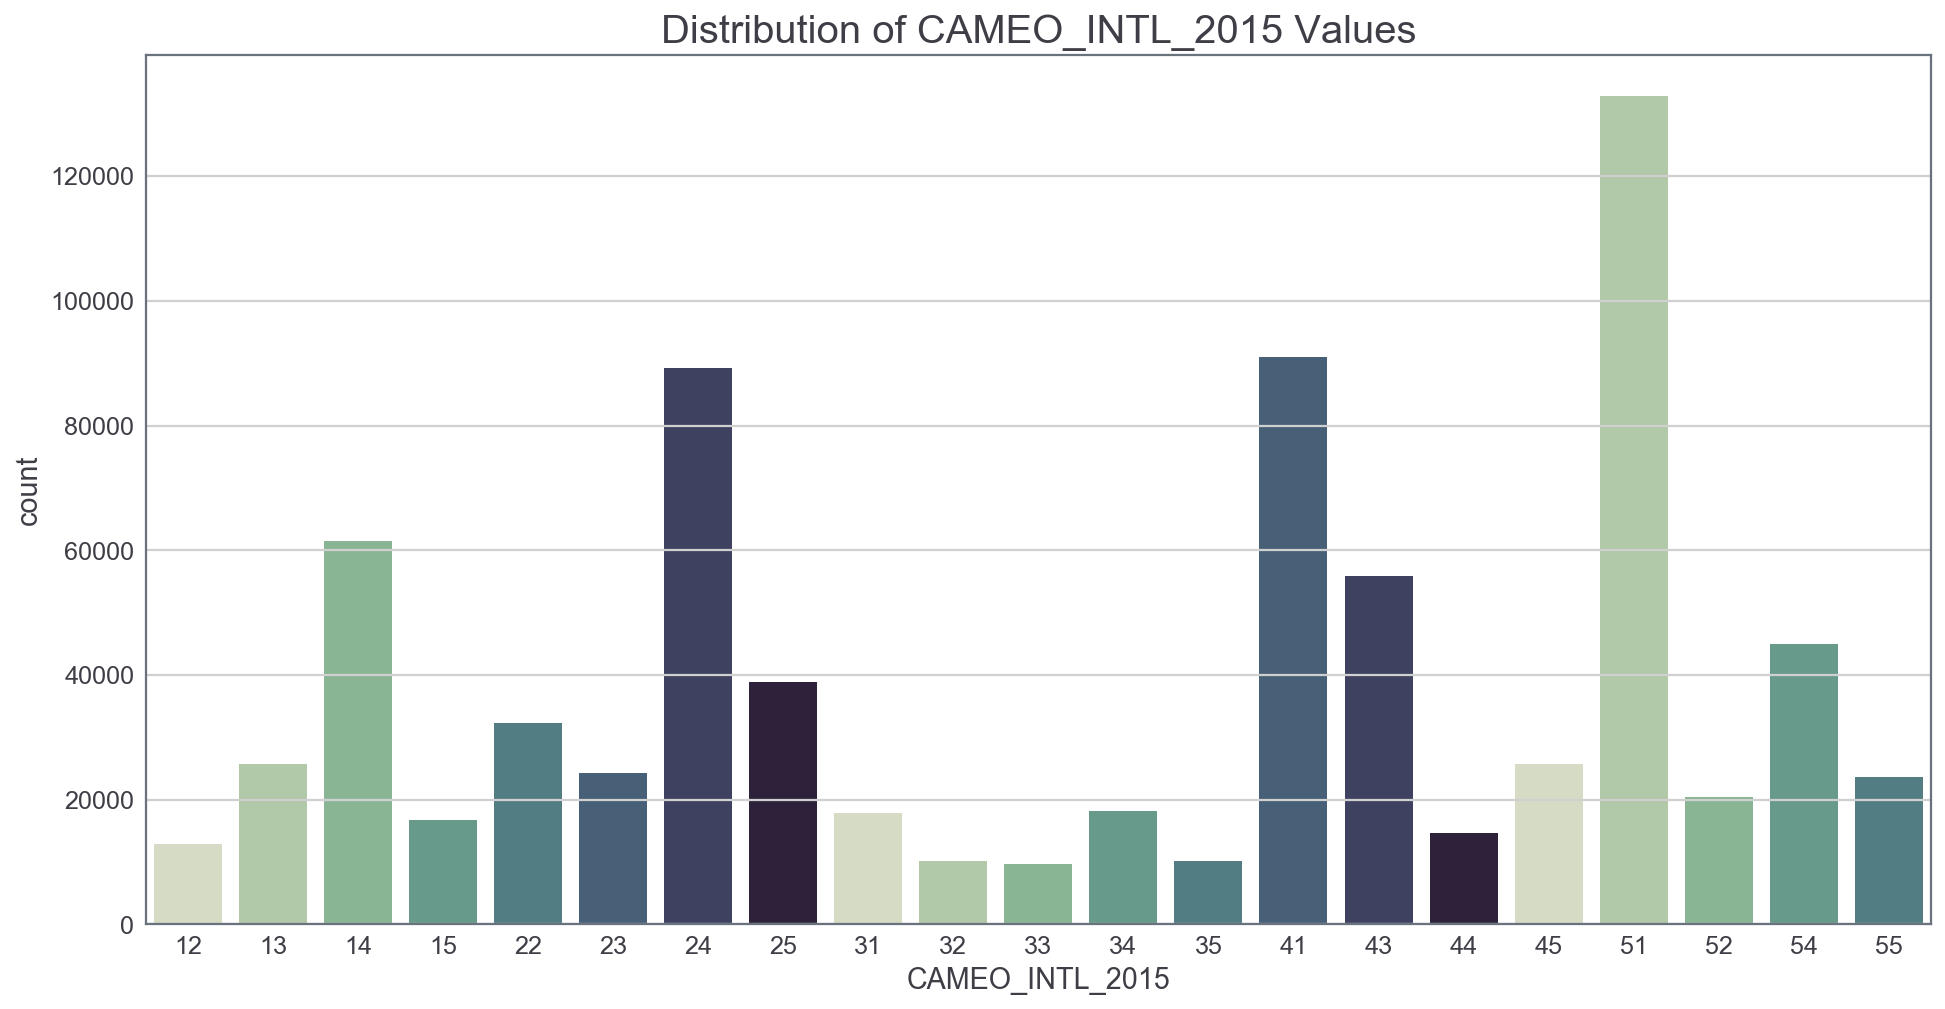

In [263]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title(
    'Distribution of CAMEO_INTL_2015 Values', fontdict={'fontsize': 20})
sns.countplot(
    data=cleaned.sort_values('CAMEO_INTL_2015'),
    x='CAMEO_INTL_2015',
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))

In [264]:
# PERECENT MISSING VALUES FROM COLUMN
print('{:.2%} NaN BEFORE RE-ENGINEERING'.format(
    cleaned['CAMEO_INTL_2015'].isnull().sum() / len(
        cleaned['CAMEO_INTL_2015'])))

0.47% NaN BEFORE RE-ENGINEERING


#### How the data looks and what it represents:
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

***

#### It appears that the first digit is indicative of socioeconomic standing (wealth) where the second digit is indicative of where they are in their life cycle. These two numbers can be extracted to become their own variables.

In [265]:
# CREATING NEW VARIABLES, EXTRACTING FIRST AND SECOND CHARACTERS AND MAPPING THEM TO A NEW COLUMN
cleaned['WEALTH'] = cleaned['CAMEO_INTL_2015'].apply(
    lambda x: int(str(x)[0]) if not pd.isna(x) else None)
cleaned['LIFE_STAGE'] = cleaned['CAMEO_INTL_2015'].apply(
    lambda x: int(str(x)[1]) if not pd.isna(x) else None)

In [266]:
# NEW SEPARATED VARIABLES
cleaned[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].sample(10)

CAMEO_INTL_2015  WEALTH  LIFE_STAGE
589560              41     4.0         1.0
68563               51     5.0         1.0
805560              44     4.0         4.0
721568              51     5.0         1.0
89197               55     5.0         5.0
278716              13     1.0         3.0
212701              51     5.0         1.0
810329              43     4.0         3.0
887465              31     3.0         1.0
86958               22     2.0         2.0

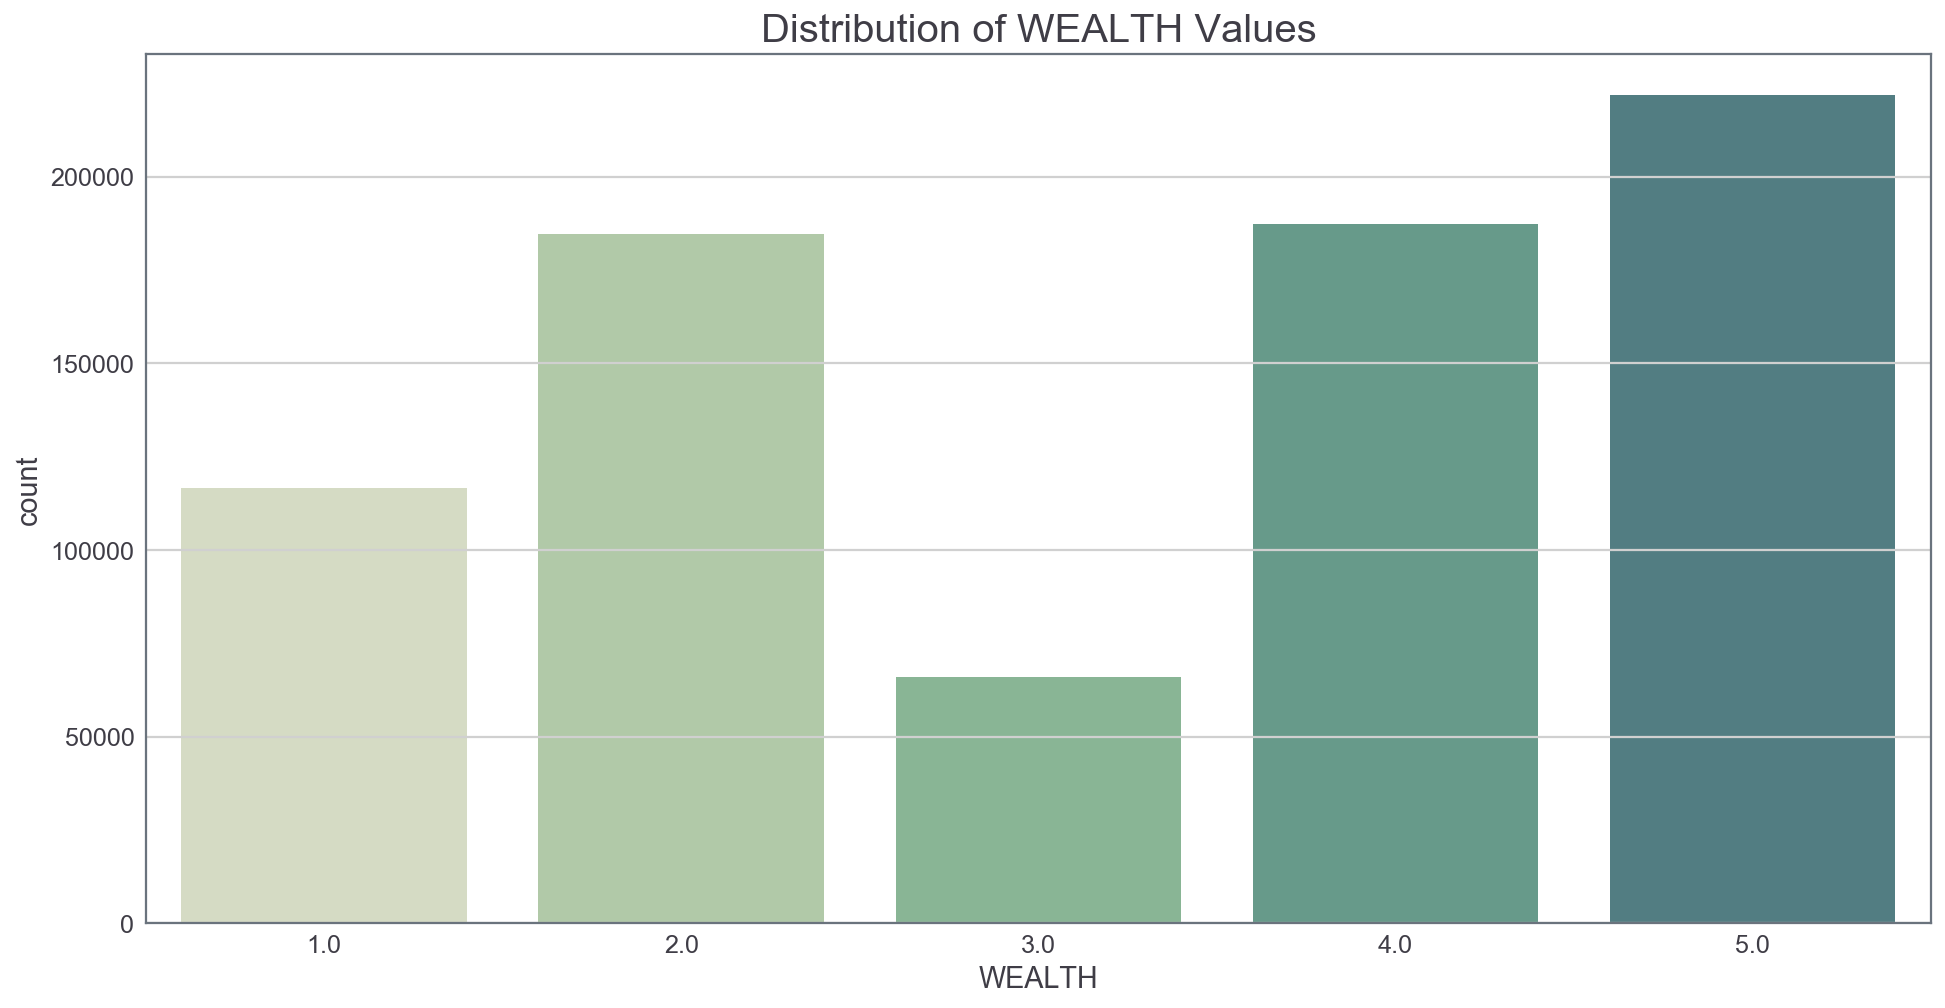

In [267]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Distribution of WEALTH Values', fontdict={'fontsize': 20})
sns.countplot(data=cleaned, x='WEALTH', ax=ax,
              palette=sns.cubehelix_palette(8, start=.5, rot=-.75));

In [268]:
print('{:.2%} NaN WEALTH AFTER RE-ENGINEERING'.format(
    cleaned['WEALTH'].isnull().sum() / len(cleaned['WEALTH'])))
# SAME PERCENT AS BEFORE, WHICH IS EXPECTED

0.47% NaN WEALTH AFTER RE-ENGINEERING


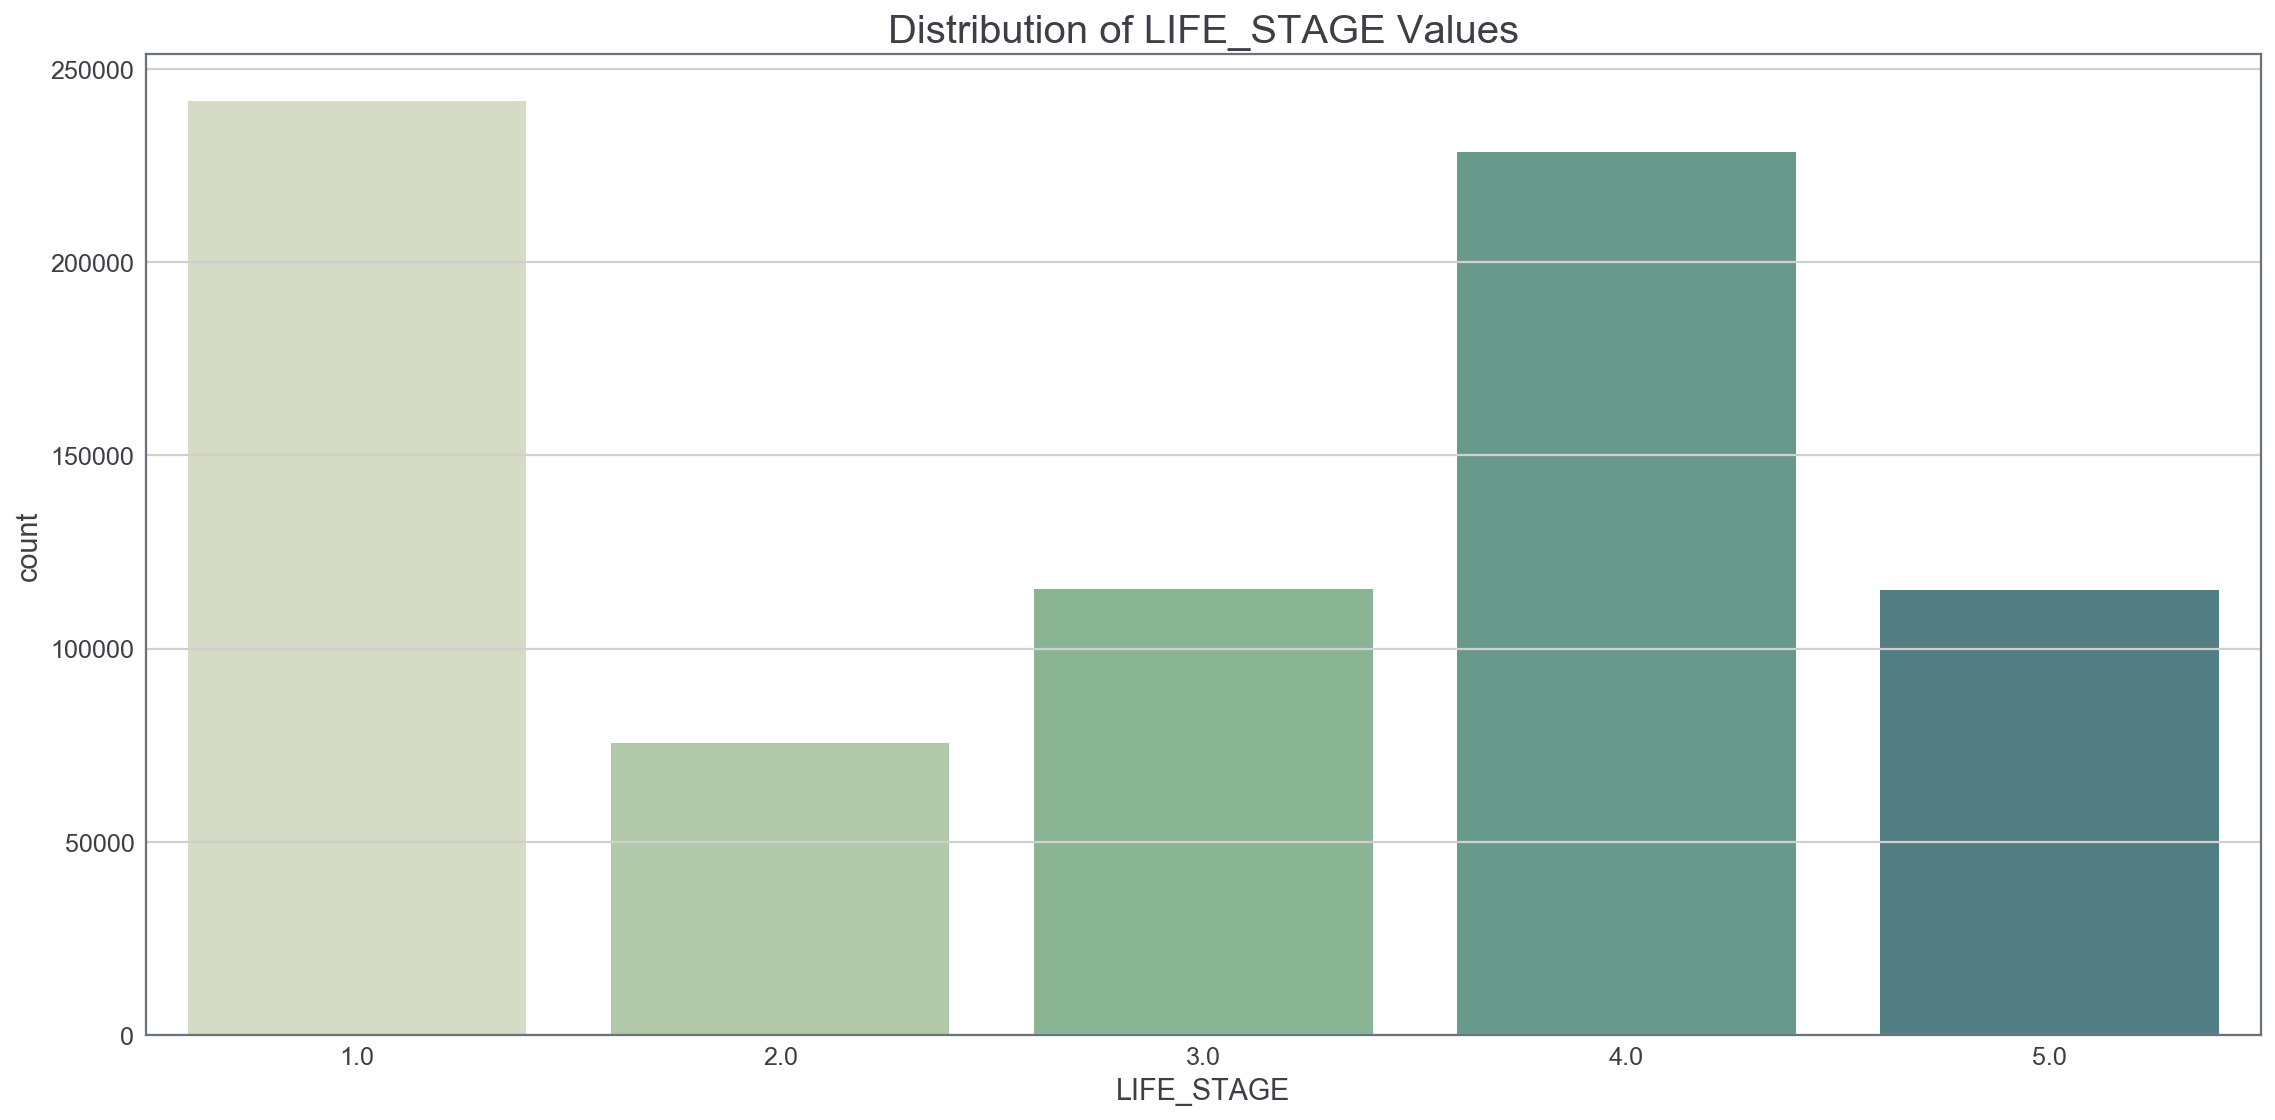

In [269]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Distribution of LIFE_STAGE Values', fontdict={'fontsize': 20})
sns.countplot(
    data=cleaned,
    x='LIFE_STAGE',
    ax=ax,
    palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
fig.tight_layout()

In [270]:
print('{:.2%} NaN LIFE_STAGE AFTER RE-ENGINEERING'.format(
    cleaned['LIFE_STAGE'].isnull().sum() / len(cleaned['LIFE_STAGE'])))
# SAME PERCENT AS BEFORE, WHICH IS EXPECTED

0.47% NaN LIFE_STAGE AFTER RE-ENGINEERING


In [271]:
# drop columns that are multi-level that aren't being included in the analysis
mixed = feat_info[feat_info['type'] == 'mixed']
mixed = mixed.drop(
    index=64)  # remove high NaN column removed from actual data earlier
mixed_unique = cleaned[mixed.attribute].nunique()

# remove columns that are no longer needed
cleaned = cleaned.drop('row NaN', axis=1)
cleaned = cleaned.drop(mixed.attribute, axis=1)
print('CLEANED DATA PREVIEW')
display(cleaned.sample(5))

CLEANED DATA PREVIEW


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
655741                   4.0          1                  5              1   
275808                   3.0          2                  2              2   
300210                   2.0          2                  1              5   
670408                   3.0          1                  3              1   
213733                   3.0          1                  3              3   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
655741                 5               1                      1   
275808                 4               4                      2   
300210                 1               5                      3   
670408                 5               2                      1   
213733                 4               2                      1   

        FINANZ_HAUSBAUER  GREEN_AVANTGARDE  HEALTH_TYP     ...      \
655741                 2                 1         2.0     ...       
275808                 2                 0         3.0     ...       
300210                 4                 0         2.0     ...       
670408                 5                 0         3.0     ...       
213733                 3                 0         3.0     ...       

        PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  DECADE  \
655741         0.0       3.0       4.0     2.0          4.0       3.0     3.0   
275808         1.0       4.0       5.0     1.0          3.0       1.0     4.0   
300210         2.0       3.0       1.0     4.0          9.0       3.0     5.0   
670408         1.0       4.0       5.0     5.0          3.0       5.0     3.0   
213733         1.0       5.0       4.0     4.0          5.0       3.0     4.0   

        MOVEMENT  WEALTH  LIFE_STAGE  
655741       2.0     1.0         4.0  
275808       1.0     2.0         2.0  
300210       1.0     5.0         1.0  
670408       1.0     1.0         4.0  
213733       1.0     2.0         4.0  

[5 rows x 64 columns]



#### Discussion 1.2.2: Engineer Mixed-Type Features

#### I removed all but two of the mixed-type features:
- `PRAEGENDE_JUGENDJAHRE`
- `CAMEO_INTL_2015`

#### The other mixed features were:
- `LP_LEBENSPHASE_FEIN`
- `LP_LEBENSPHASE_GROB`
- `WOHNLAGE`
- `PLZ8_BAUMAX`

#### If these were kept in the analysis there would be a significant amount of dummy variables needed, which drove the decision to drop them from the data.

#### The PRAEGENDE_JUGENDJAHRE feature contained the movement of a person's youth, and the mapping of these various variable types can be found above. I engineered two new variables from the original feature, and they are:
1. `DECADE`: The individual's decade associated with their youth (data ranges from 1 - 6)
2. `MOVEMENT`: Movement the individual aligns with their youth (1: Mainstream, 2: Avantgarde)

#### The mixed feature CAMEO_INTL_2015 contained information regarding the individual's wealth and life stage typology, where the first digit of a two digit integer represented their wealth, and the second digit their life stage. I extracted the integers and mapped them to new columns. The resulting columns are:

1. `WEALTH`: Integer ranging from 1 to 5 indiating level of household wealth (1 is wealthy, 5 poorer)
2. `LIFE_STAGE`: Integer ranging from 1 to 5 indicating life stage (1 is young, 5 is elderly)

#### I removed the original columns for the two mixed features I kept, as they would muddy the analysis by creating correlations that aren't independent.


#### Step 1.2.3: Complete Feature Selection

In [272]:
print('ALL NUMERIC DATA TYPES! Ready for analysis')
print('*' * 50)
display(cleaned.info())

ALL NUMERIC DATA TYPES! Ready for analysis
**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
RETOURTYP_BK_S           776319 non-null float64
SEMIO_SOZ                780153 non-null int64
SEMIO_FAM                780153 non-null int64
SEMIO_REL                780153 non-null int64
SEMIO_MAT                780153 non-null int64
SEMIO_VERT               780153 non-null int64
SEMIO_LUST               780153 non-n

None

### Step 1.3: Create a Cleaning Function

In [273]:
# helper functions for cleaning


def missing_to_NaN(df):
    '''
    INPUT: DataFrame
    OUTPUT: DataFrame with unknown value codes converted to NaNs
    '''
    for i in range(len(feat_info)):  # iterate through all columns
        unknown_list = feat_info['missing_or_unknown'].iloc[i]
        if len(unknown_list) == 0:
            pass  # skips values that have already been converted to NaNs)

        for x in range(len(feat_info['missing_or_unknown'].iloc[
                i])):  # iterate through missing/unknown list
            # iterate through missing values for each column, if matches, replace with np.nan
            (df[feat_info['attribute'][i]].replace(
                unknown_list, np.nan, inplace=True))
    return df


def split_based_on_NaN(df, percent_split=10):
    '''
    INPUT: 
        - DataFrame
        - Integer of percent threshold to split DataFrame by (default 10)
    OUTPUT: 
        - Low NaN DataFrame, High NaN DataFrame
    '''

    # add a column to DF with sum of NaN values in row
    df['row_NaN'] = df.isnull().sum(axis=1)

    # create subset of data where sum of NaNs per row is less than or equal to 10
    df_lowNaN = df.loc[df['row_NaN'] <= percent_split]

    # create subset of data where sum of NaNs per row is greater than 10
    df_highNaN = df.loc[df['row_NaN'] > percent_split]

    return df_lowNaN, df_highNaN


def encode_and_remove_categ(df):
    '''
    INPUT: 
        - DataFrame
    OUTPUT: 
        - DataFrame with binary values numerically 
        encoded and multi-level columns removed
    '''

    # encode binary column to numeric values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

    # drop multi level categorical features
    df = df.drop(
        columns=categorical.loc[categorical['sub_type'] == 'multi'].key_0)

    return df


def create_mixed_features(df):
    '''
    INPUT: 
        - DataFrame
    OUTPUT: 
        - DataFrame with new variables created from mixed features, removes old features
    '''
    decades_map = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        6: 3,
        7: 3,
        8: 4,
        9: 4,
        10: 5,
        11: 5,
        12: 5,
        13: 5,
        14: 6,
        15: 6
    }

    movements_map = {
        1: 1,
        2: 2,
        3: 1,
        4: 2,
        5: 1,
        6: 2,
        7: 2,
        8: 1,
        9: 2,
        10: 1,
        11: 2,
        12: 1,
        13: 2,
        14: 1,
        15: 2
    }

    df['DECADE'] = df.PRAEGENDE_JUGENDJAHRE.map(decades_map)
    df['MOVEMENT'] = df.PRAEGENDE_JUGENDJAHRE.map(movements_map)

    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(
        lambda x: int(str(x)[0]) if not pd.isna(x) else None)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(
        lambda x: int(str(x)[1]) if not pd.isna(x) else None)

    mixed = feat_info[feat_info['type'] == 'mixed']

    # remove high NaN column removed from actual data earlier
    mixed = mixed.drop(index=64)
    mixed_unique = df[mixed.attribute].nunique()
    df = df.drop('row_NaN', axis=1)
    df = df.drop(mixed.attribute, axis=1)

    return df

In [274]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: 
        - Demographics DataFrame
    OUTPUT: 
        - Trimmed and cleaned demographics DataFrame, high NaN DataFrame
    """

    print('=> encoding missing values as NaN')
    df = missing_to_NaN(df)

    # remove selected columns and rows, ...
    print('=> removing columns selected')
    columns_to_remove = missing.index[:6]  # same columns as above
    df = df.drop(columns_to_remove, axis=1)

    # split into two datasets, one with high NaNs and one with low NaNs
    print(
        '=> splitting into two datasets, one with high NaNs and one with low NaNs'
    )
    df, df_highNaN = split_based_on_NaN(df)

    # select, re-encode, and engineer column values.
    print(
        '=> re-encoding binary values and removing multi-level categorical columns'
    )
    df = encode_and_remove_categ(df)
    print(
        '=> creating mixed features and removing other mixed feature columns')
    df = create_mixed_features(df)

    # Return the cleaned dataframes

    print('=> done!')

    return df, df_highNaN

In [275]:
test, test_high = clean_data(data_raw)

=> encoding missing values as NaN
=> removing columns selected
=> splitting into two datasets, one with high NaNs and one with low NaNs
=> re-encoding binary values and removing multi-level categorical columns
=> creating mixed features and removing other mixed feature columns
=> done!


In [276]:
print('TEST HIGH NaN')
print(test_high['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(test_high.shape)
print('--------------------------')
print('TEST')
print(test['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(test.shape)
print('--------------------------')
print('CONTROL DATA')
print(cleaned['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(cleaned.shape)

TEST HIGH NaN
[ 1.  2.  3.  4. nan]
(111068, 80)
--------------------------
TEST
[ 1.  2.  3.  4. nan]
(780153, 64)
--------------------------
CONTROL DATA
[ 1.  2.  3.  4. nan]
(780153, 64)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [277]:
# percent of nans remaining in cleaned data, per top 15 columns
(cleaned.isnull().mean(axis=0) * 100).sort_values(ascending=False).head(15)

W_KEIT_KIND_HH    7.214226
REGIOTYP          7.021443
KKK               7.021443
VERS_TYP          4.425286
HEALTH_TYP        4.425286
DECADE            3.393437
MOVEMENT          3.393437
KBA05_ANTG2       3.134898
KBA05_ANTG3       3.134898
KBA05_ANTG1       3.134898
KBA05_ANTG4       3.134898
KBA05_GBZ         3.134898
MOBI_REGIO        3.134898
PLZ8_GBZ          1.040181
PLZ8_HHZ          1.040181
dtype: float64

#### `W_KEIT_KIND_HH` has the highest missing values per COLUMN, with two others not too far behind

In [278]:
# proportion of NaNs for each row
row_nans = (cleaned.isnull().mean(axis=1) * 100).sort_values(ascending=False)
print('5 rows with highest % of NaNs')
print('-------------------------------')
print(row_nans.head())

# calculate how many rows have NaNs
rows_w_NaNs = len(row_nans[row_nans > 0])
print('')
print('-------------------------------')
print('{} rows have at least one NaN'.format(rows_w_NaNs))
print('{:.2%} of rows contain at least one NaN, too much!'.format(
    rows_w_NaNs / len(cleaned)))

# how many NaNs as a percentage of the entire dataset?
total_NaN_perc = (
    cleaned.isnull().sum().sum() / (cleaned.shape[0] * cleaned.shape[1]))
print('')
print('-------------------------------')
print("""{:.2%} of all feature values are NaNs which is reasonable,
but we can\'t simply discard them because it would remove 1/5 of our data"""
      .format(total_NaN_perc))
print('')
print('-------------------------------')
print(
    """We need to remove all of the NaNs, scale our data on the removed NaN-removed 
data, and then impute the NaNs on the full dataset""")

5 rows with highest % of NaNs
-------------------------------
291199    17.1875
153291    17.1875
453419    17.1875
374634    17.1875
511761    17.1875
dtype: float64

-------------------------------
156942 rows have at least one NaN
20.12% of rows contain at least one NaN, too much!

-------------------------------
1.06% of all feature values are NaNs which is reasonable,
but we can't simply discard them because it would remove 1/5 of our data

-------------------------------
We need to remove all of the NaNs, scale our data on the removed NaN-removed 
data, and then impute the NaNs on the full dataset


In [279]:
# fitting the scaler object on data with NaNs removed to not skew results
cleaned_dropped_NaN = cleaned.dropna(
)  # defaults to dropping rows with at least one NaN

scaler = StandardScaler()  # initialise the scaler object

print(cleaned_dropped_NaN.shape)
display(scaler.fit(cleaned_dropped_NaN))  # fit to cleaned dropped NaN data

(623211, 64)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [280]:
# imputing missing values using each column's respective mean
imputer_obj = Imputer()  # default args, missing='NaN' strategy='mean', axis=0

imputed = imputer_obj.fit_transform(
    cleaned)  # fit to cleaned data with NaNs (no labels)

# RETURNS A NUMPY ARRAY
print('Imputed type: {}'.format(type(imputed)))
print('Imputed shape: {}'.format(imputed.shape))

Imputed type: <class 'numpy.ndarray'>
Imputed shape: (780153, 64)


In [281]:
# still need to transform the imputed data with the scaler that was fit above

imputed_scaled = scaler.transform(imputed)
print('Imputed_scaled type: {}'.format(type(imputed_scaled)))
print('Imputed_scaled shape: {}'.format(imputed_scaled.shape))

Imputed_scaled type: <class 'numpy.ndarray'>
Imputed_scaled shape: (780153, 64)


In [282]:
# convert scaled and imputed data back into a pandas DF
clean_scaled = pd.DataFrame(imputed_scaled, columns=cleaned.columns)
cleaned_scaled_NaNs = clean_scaled.isnull().sum().sum()

print('Scaled data shape: {}'.format(clean_scaled.shape))
print('-' * 40)
print('{} NaNs after imputation and scaling! :)'.format(cleaned_scaled_NaNs))
print('')
print('Let\'s look at how the data looks now')
print('-' * 40)
display(clean_scaled.describe())

Scaled data shape: (780153, 64)
----------------------------------------
0 NaNs after imputation and scaling! :)

Let's look at how the data looks now
----------------------------------------


ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         780153.000000  780153.000000      780153.000000  780153.000000   
mean               0.005104       0.020054          -0.005249       0.023507   
std                0.991111       0.999350           1.012659       1.012004   
min               -1.746287      -1.022678          -1.512226      -1.141397   
25%               -0.772089      -1.022678          -0.777350      -1.141397   
50%                0.202108       0.977825          -0.042475       0.219832   
75%                1.176305       0.977825           0.692400       0.900446   
max                1.176305       0.977825           1.427276       1.581061   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     780153.000000   780153.000000          780153.000000   
mean          -0.008934        0.047022               0.051743   
std            0.991257        1.016879               1.015572   
min           -1.765054       -1.221852              -1.139026   
25%           -1.045045       -1.221852              -1.139026   
50%            0.394972        0.158605              -0.410325   
75%            1.114980        0.848833               1.047076   
max            1.114980        1.539061               1.775776   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP      ...        \
count     780153.000000     780153.000000  780153.000000      ...         
mean          -0.018721         -0.034343      -0.004805      ...         
std            1.024366          0.977655       0.973106      ...         
min           -1.588887         -0.553672      -1.591635      ...         
25%           -0.856544         -0.553672      -0.273495      ...         
50%           -0.124201         -0.553672      -0.273495      ...         
75%            0.608142         -0.553672       1.044646      ...         
max            1.340485          1.806125       1.044646      ...         

          PLZ8_ANTG4       PLZ8_HHZ       PLZ8_GBZ         ARBEIT  \
count  780153.000000  780153.000000  780153.000000  780153.000000   
mean       -0.025578      -0.001920       0.026657      -0.025217   
std         0.988839       1.007932       0.993305       1.005138   
min        -0.981973      -2.721004      -2.111170      -2.223015   
25%        -0.981973      -0.639701      -0.314765      -0.201175   
50%         0.384671      -0.001920      -0.314765      -0.201175   
75%         0.384671       0.400951       0.583438       0.809745   
max         1.751315       1.441603       1.481641       1.820665   

         ORTSGR_KLS9       RELAT_AB         DECADE       MOVEMENT  \
count  780153.000000  780153.000000  780153.000000  780153.000000   
mean       -0.038275      -0.025203       0.009594      -0.016101   
std         1.000317       1.003538       0.987504       0.972798   
min        -1.914219      -1.563993      -2.280170      -0.553672   
25%        -0.607437      -0.823841      -0.902320      -0.553672   
50%        -0.171843      -0.083688       0.009594      -0.553672   
75%         0.699344       0.656464       1.164455      -0.016101   
max         1.570532       1.396616       1.164455       1.806125   

              WEALTH     LIFE_STAGE  
count  780153.000000  780153.000000  
mean       -0.035876      -0.003388  
std         1.002911       0.990054  
min        -1.595951      -1.251111  
25%        -0.909992      -1.251111  
50%         0.461926       0.082843  
75%         1.147884       0.749820  
max         1.147884       1.416797  

[8 rows x 64 columns]

In [283]:
def col_compare(df1, df2, col, title_1, title_2):
    '''
    INPUT:
        df1: DataFrame with exactly same columns as other DF
        df2: DataFrame with exactly same columns as other DF
        col: str of column label wished to be compared
        title_1: str of title for first plot
        title_2: str of title for second plot
    OUTPUT:
        Two plots
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    f.dpi = 85
    ax1.set_title(title_1)
    ax2.set_title(title_2)
    sns.countplot(
        x=col,
        data=df1,
        ax=ax1,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
    sns.countplot(
        x=col,
        data=df2,
        ax=ax2,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
    f.tight_layout()

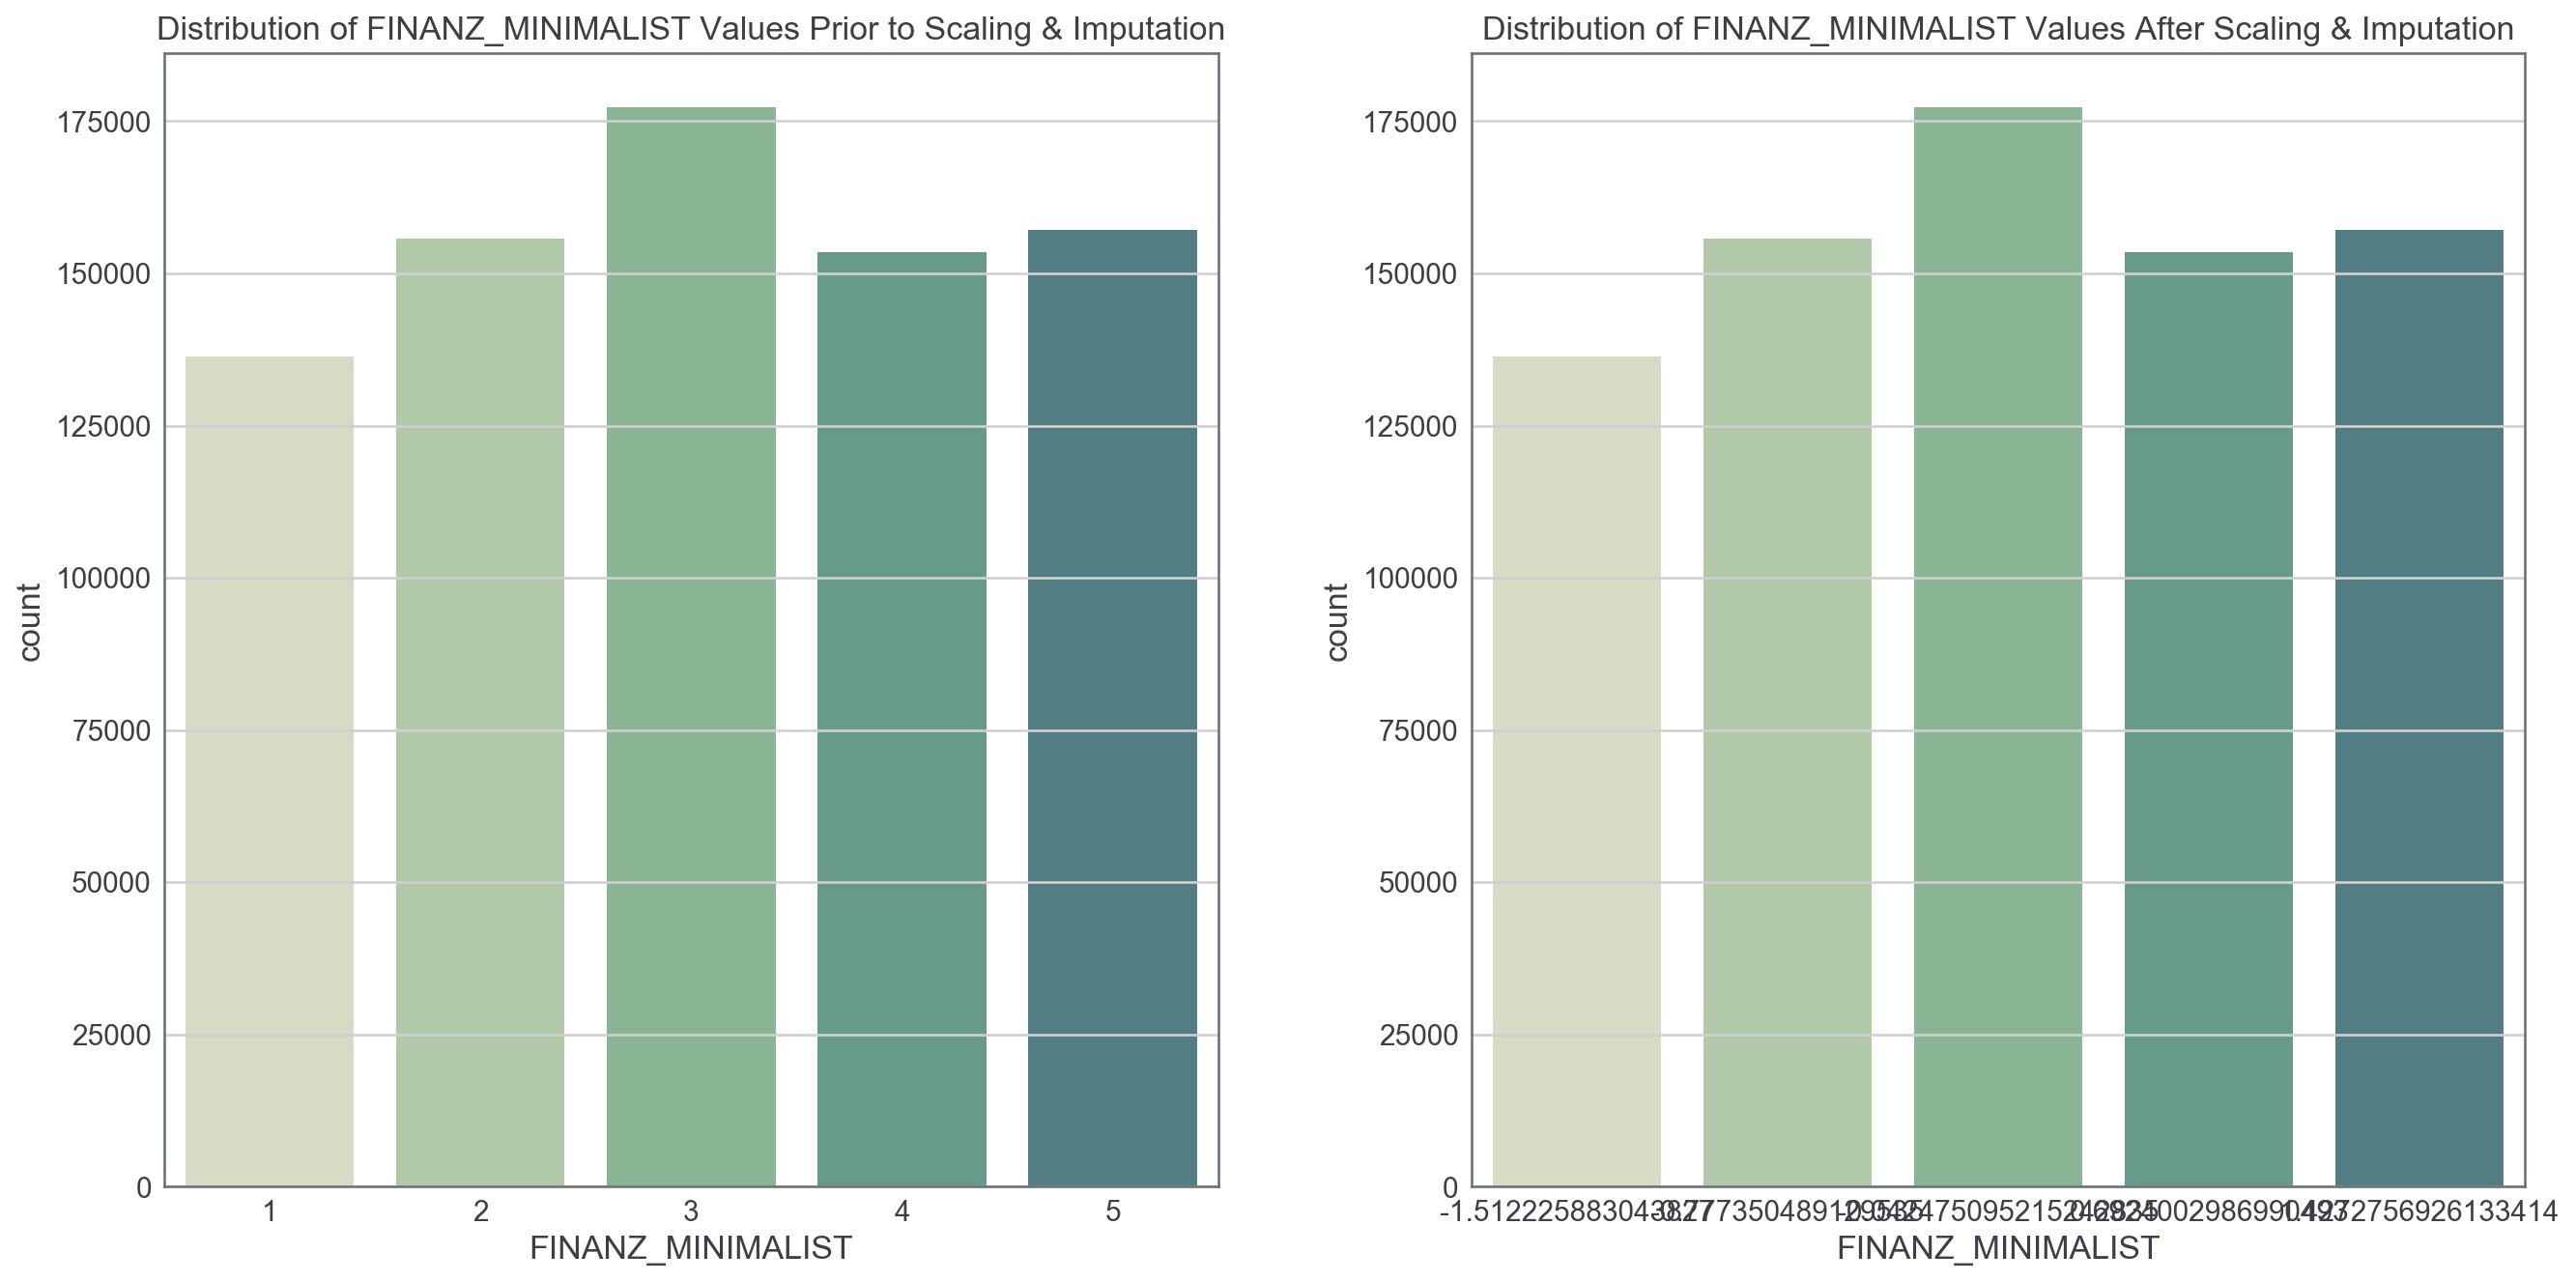

In [284]:
col_compare(
    cleaned, clean_scaled, 'FINANZ_MINIMALIST',
    'Distribution of FINANZ_MINIMALIST Values Prior to Scaling & Imputation',
    'Distribution of FINANZ_MINIMALIST Values After Scaling & Imputation')

# DISTRIBUTION OF VALUES IS THE SAME BEFORE AND AFTER SCALING / IMPUTING

### Discussion 2.1: Apply Feature Scaling

#### As seen above, approximately 20% of rows contained at least one NaN value, so dropping those rows entirely would greatly hinder and skew the results of our analysis. I dropped all of the NaNs to create a dataset to initialise the `StandardScaler` with; I then used this scaler to impute the mean (which is zero), which stabalises the data more than leaving NaNs. 

#### The resulting data's features have maximums and minimums around 1 and -1, respectively. This will allow for much easier analysis time-wise.

### Step 2.2: Perform Dimensionality Reduction

In [285]:
# create PCA object
pca_obj = PCA(random_state=41).fit(clean_scaled)

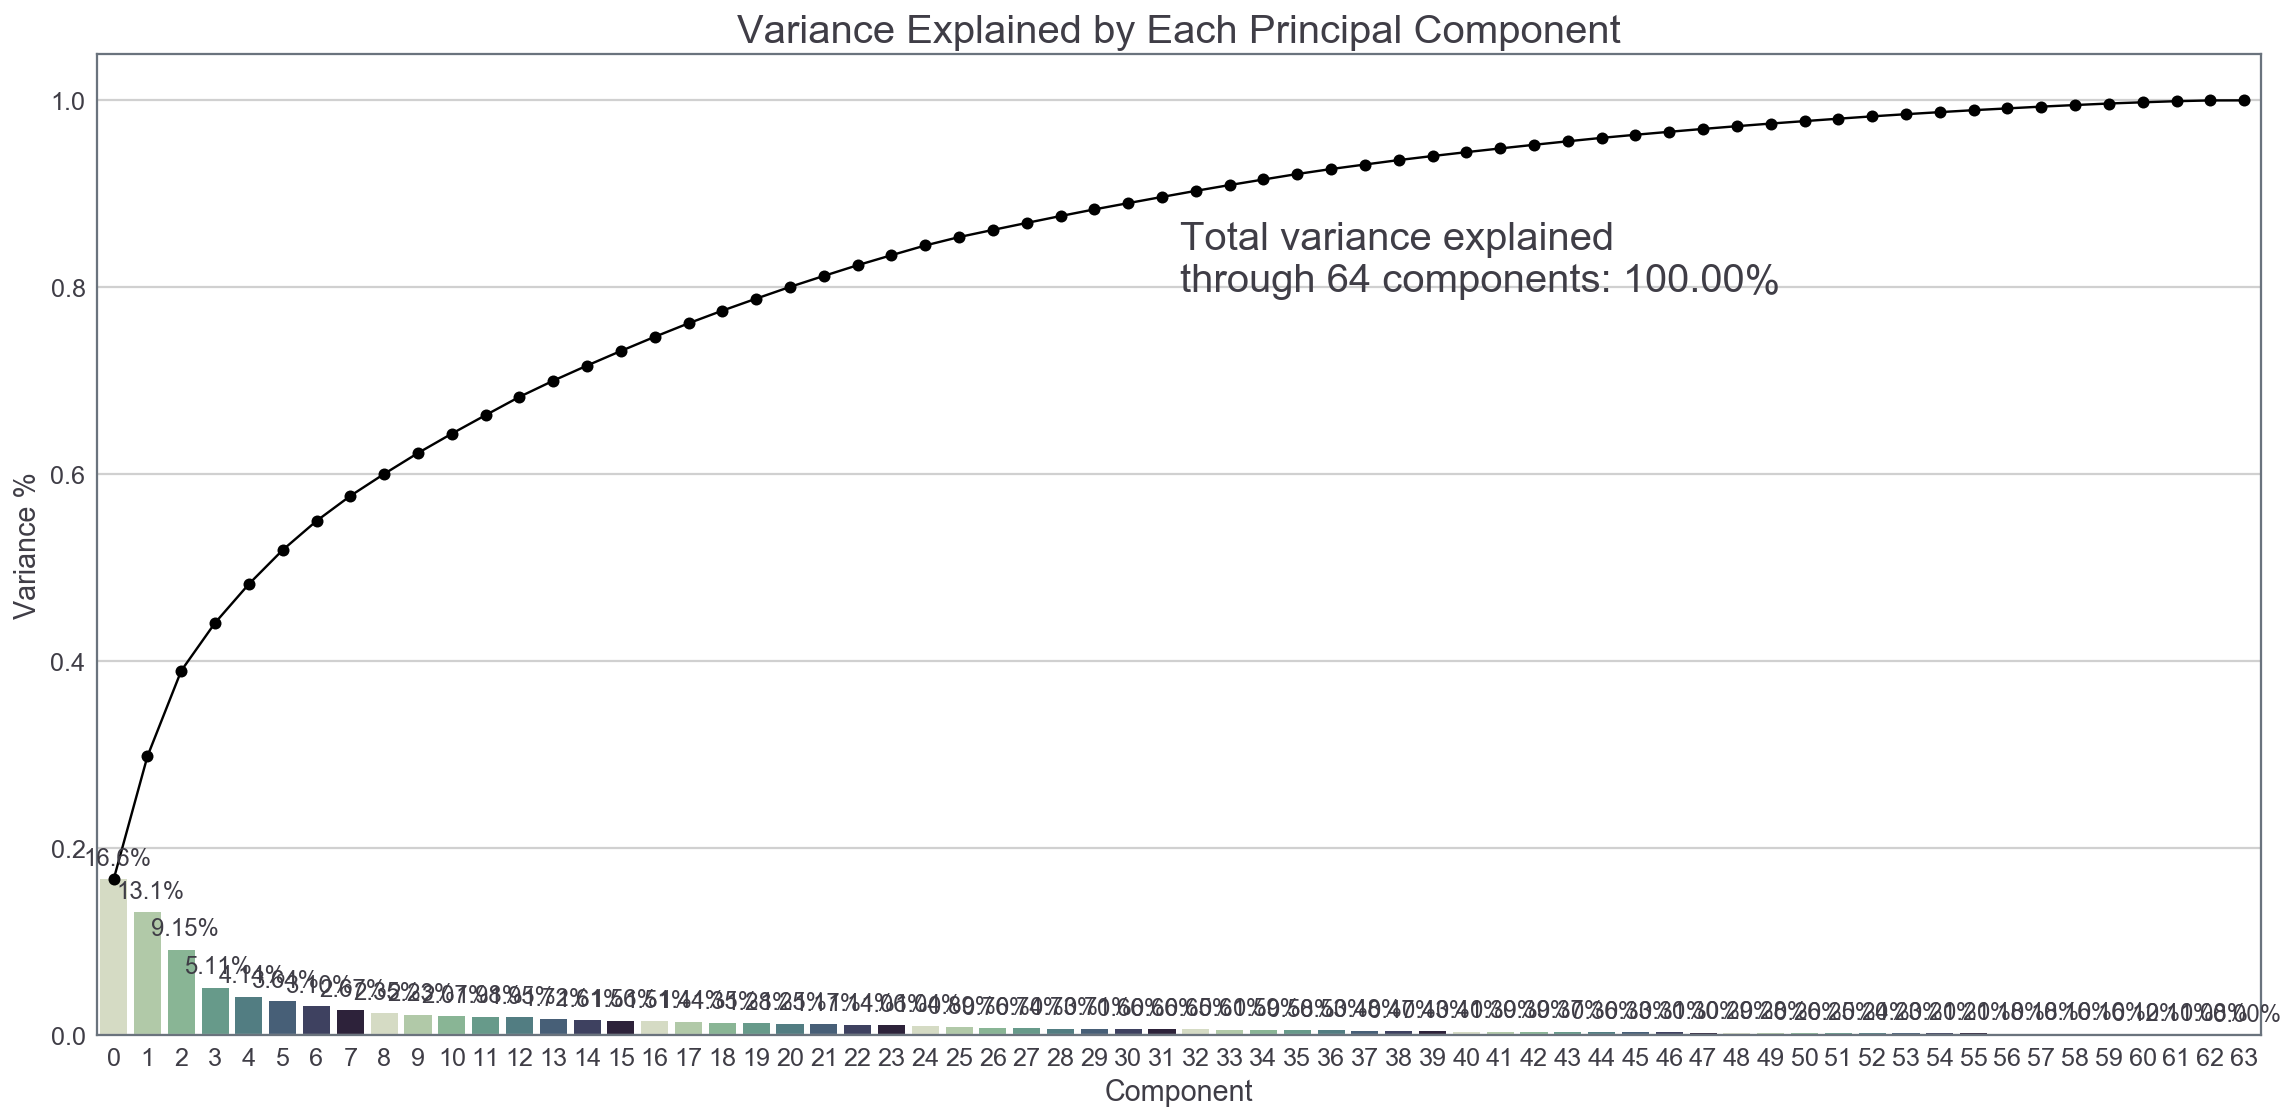

In [286]:
def scree(pca):
    n_comps = len(pca.components_)  # number of components
    x_axis = np.arange(n_comps)  # axis for graph
    comp_vars = pca.explained_variance_ratio_  # variance values per component

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(
        'Variance Explained by Each Principal Component',
        fontdict={'fontsize': 20})
    ax.set_ylabel('Variance %')
    ax.set_xlabel('Component')
    sns.barplot(
        x_axis,
        comp_vars,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75),
        ax=ax)
    ax.plot(np.cumsum(comp_vars), marker='o', ms=6, c='black')
    ax.set_xticks(x_axis)
    total_var = np.cumsum(comp_vars[:n_comps])
    for i in range(n_comps):
        ax.annotate(
            r"%s%%" % ((str(comp_vars[i] * 100)[:4])),
            (x_axis[i] + 0.1, comp_vars[i] + .01),
            va="bottom",
            ha="center",
            fontsize=12)
    ax.annotate(
        'Total variance explained\nthrough {} components: {:.2%}'.format(
            n_comps, total_var[-1]),
        xy=(x_axis.mean(), total_var[int(n_comps / 2)]),
        xycoords='data',
        size=20,
        textcoords='offset pixels',
        xytext=(1, -100))
    fig.tight_layout()


scree(pca_obj)

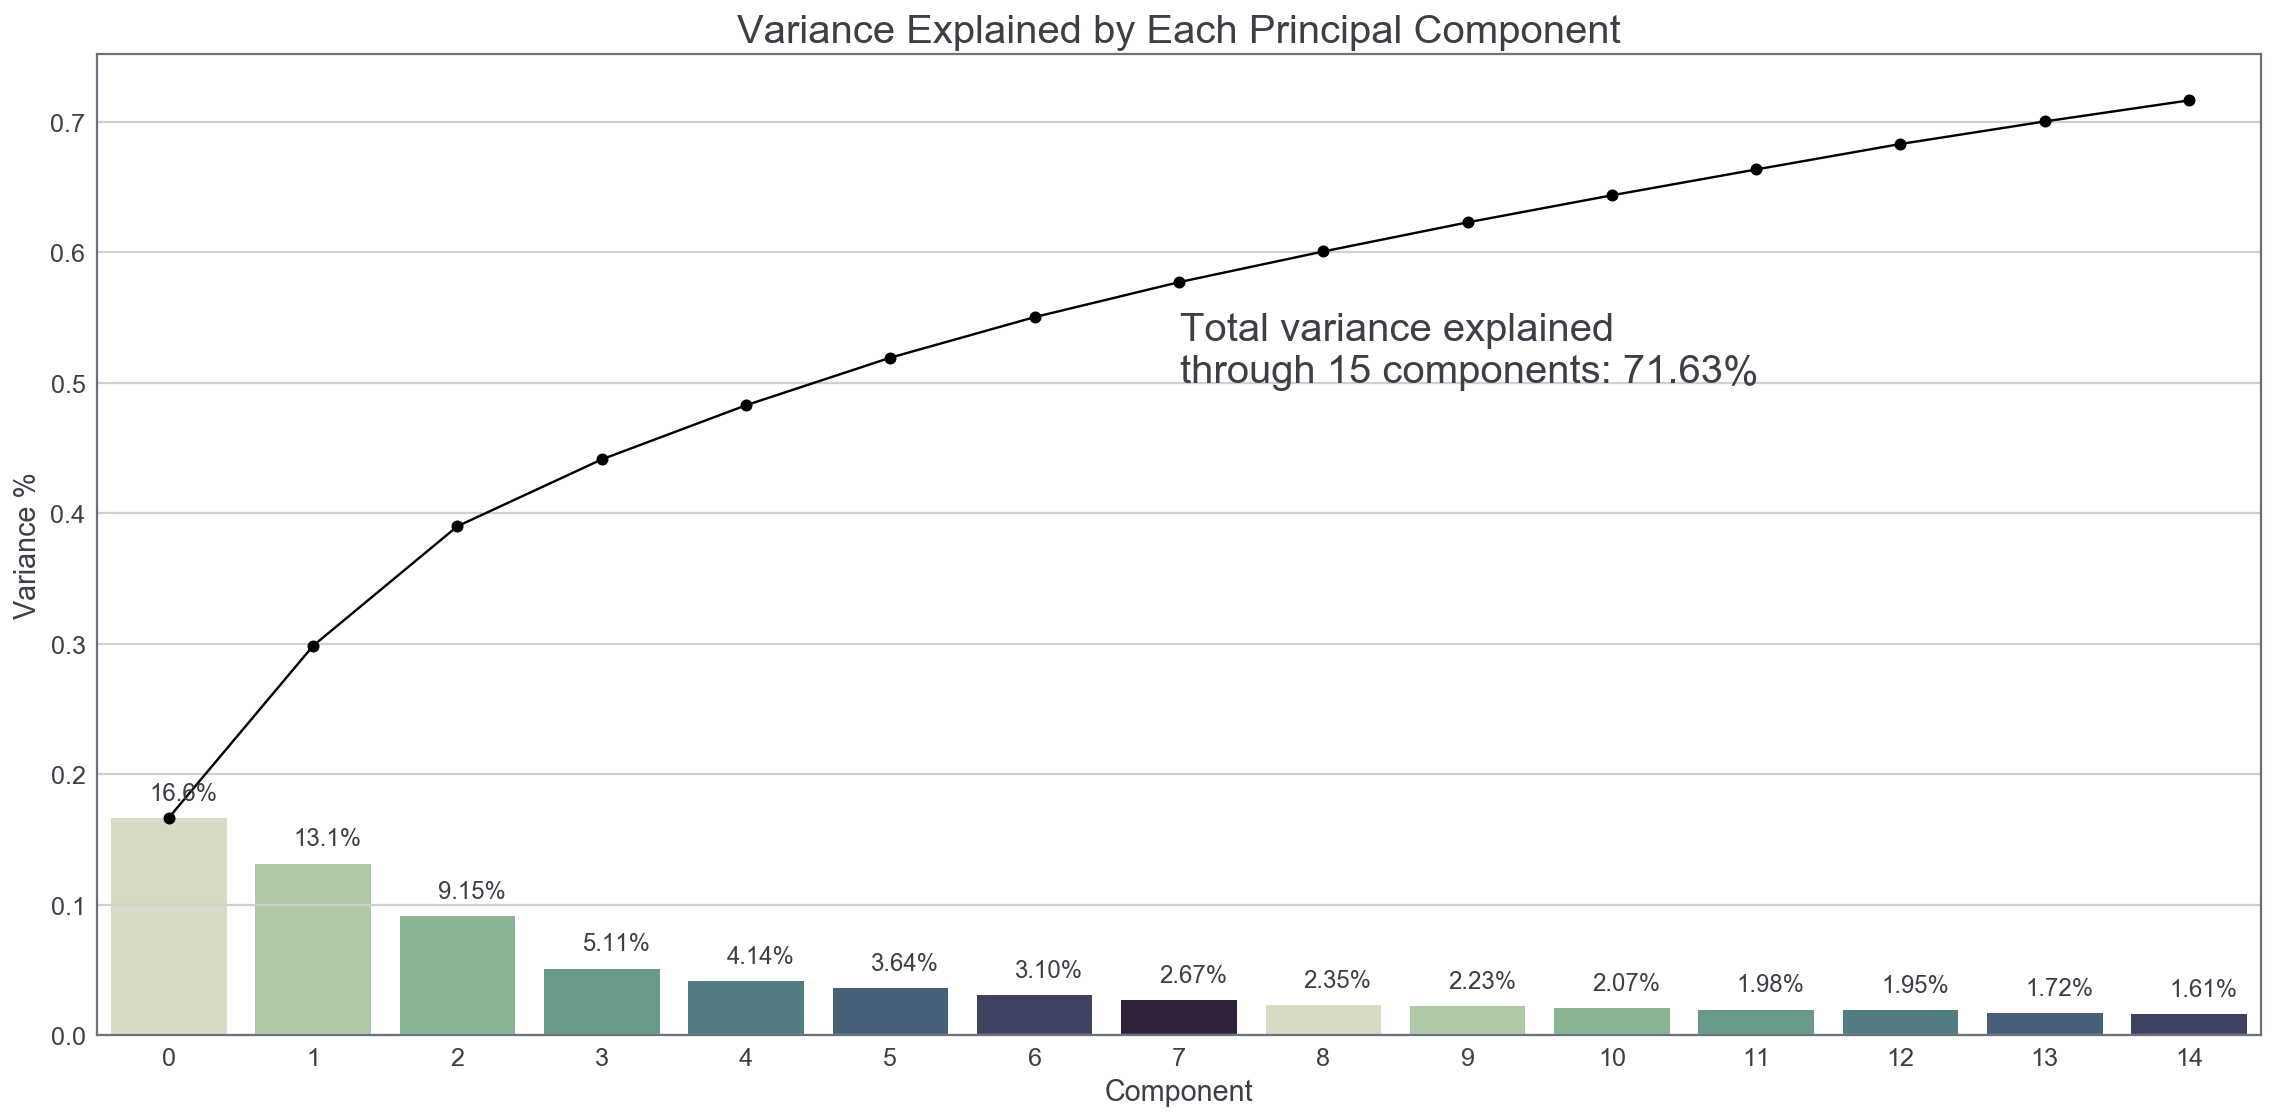

In [287]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_obj_15 = PCA(
    n_components=15, random_state=41).fit(
        clean_scaled)  # create PCA object with specified component amount
PCA_df = pd.DataFrame(pca_obj_15.fit_transform(
    clean_scaled))  # create DF, fitting and transforming dataframe

# plot
scree(pca_obj_15)

In [288]:
print('PCA_df shape: {}'.format(PCA_df.shape))
print('First five rows of new DataFrame')
display(PCA_df.head())
print('Summary statistics of new DataFrame')
display(PCA_df.describe())

PCA_df shape: (780153, 15)
First five rows of new DataFrame


0         1         2         3         4         5         6   \
0  3.846361 -2.726930 -2.867363 -0.324557 -1.639765  2.077211  2.089602   
1 -0.833240  0.275282 -3.029907  2.313927 -0.863935  0.356986 -0.029824   
2 -4.098978  1.241071 -0.834071 -1.070856  1.881718  0.690352 -0.141092   
3  0.582445  0.246126  3.265637  0.666708  0.307136 -1.798126 -2.567223   
4 -0.708048 -1.246973 -1.007234 -1.564273 -3.103180  1.857025 -0.852480   

         7         8         9         10        11        12        13  \
0  0.939435  1.386357 -0.480241 -0.207725 -1.914116 -0.342221  0.563369   
1 -1.040952  0.868640 -1.184890 -0.728462  0.441334 -0.411790 -2.196489   
2 -0.458998 -1.077109 -0.318556  0.281728  0.621609 -0.356558  0.864970   
3  2.318029  1.176408 -0.620048  1.160332 -1.042665  1.119260 -1.445573   
4 -0.629721 -2.751938  1.540736 -0.386989 -2.325241  0.986601  0.652520   

         14  
0 -2.586844  
1 -0.608228  
2 -0.139269  
3  0.737194  
4 -0.650225

Summary statistics of new DataFrame


0             1             2             3             4   \
count  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05   
mean   3.031705e-16 -4.689539e-16 -4.904459e-16  4.562634e-17 -1.977563e-16   
std    3.298678e+00  2.930686e+00  2.443636e+00  1.827225e+00  1.645177e+00   
min   -8.286747e+00 -8.088012e+00 -5.387536e+00 -6.231482e+00 -6.552690e+00   
25%   -2.808320e+00 -2.270536e+00 -2.202085e+00 -1.289159e+00 -9.900125e-01   
50%   -1.682181e-01  9.183747e-02 -4.652265e-01 -1.932439e-01 -2.595659e-01   
75%    2.689217e+00  2.161303e+00  2.293271e+00  1.081784e+00  5.931991e-01   
max    1.227337e+01  1.083336e+01  6.730484e+00  8.321794e+00  1.101559e+01   

                 5             6             7             8             9   \
count  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05   
mean  -1.515691e-16  1.931651e-17 -3.143243e-16 -2.860606e-16  3.533560e-16   
std    1.541417e+00  1.423606e+00  1.321210e+00  1.238148e+00  1.206511e+00   
min   -5.642630e+00 -3.730740e+00 -5.467984e+00 -6.883426e+00 -5.037574e+00   
25%   -1.064360e+00 -9.287756e-01 -8.905882e-01 -8.500144e-01 -8.229396e-01   
50%   -1.306753e-01 -1.126040e-01  2.638456e-02 -6.548472e-02 -5.193780e-03   
75%    9.463117e-01  7.221435e-01  9.115392e-01  7.976407e-01  8.100843e-01   
max    8.636837e+00  3.261570e+01  1.305857e+01  1.414612e+01  1.112503e+01   

                 10            11            12            13            14  
count  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05  7.801530e+05  
mean   2.116675e-16 -1.166103e-17  1.092074e-16  3.602508e-16  4.962724e-16  
std    1.162307e+00  1.136985e+00  1.128079e+00  1.060839e+00  1.026222e+00  
min   -5.115652e+00 -6.349706e+00 -2.599811e+00 -4.727773e+00 -4.520391e+00  
25%   -7.666642e-01 -7.766671e-01 -4.738406e-01 -6.923699e-01 -6.940965e-01  
50%    5.311517e-02  2.495000e-02 -5.844422e-02  1.534276e-02  8.939405e-03  
75%    8.082232e-01  7.788615e-01  3.430387e-01  7.134785e-01  6.952042e-01  
max    9.765003e+00  1.244085e+01  5.027325e+01  5.193245e+00  7.115252e+00

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

#### I applied PCA to the data without specifying a number of components at first, to see if I could spot a good cut off point. Through 15 components the total amount of variance explained is 71.63%, and does not increase significantly after that. 15 seemed like a good number, as 10 only explained 62.28% of variance. 

### Step 2.3: Interpret Principal Components

In [289]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weight_feats(pca_obj, df, component):
    '''
    INPUT: 
        pca_obj - Fit PCA object
        df - DataFrame with full data
        component - integer (starting at 0) of component
    OUTPUT: 
        positive_comp - pandas series with positive weights
        negative_comp - pandas series with negative weights
    '''
    w = pd.DataFrame(np.round(pca_obj.components_, 6), columns=df.keys())
    comp = w.iloc[component, :]
    positive_comp = comp[comp > 0].sort_values(ascending=False)
    negative_comp = comp[comp < 0].sort_values(ascending=True)

    return positive_comp, negative_comp

In [290]:
pos_comp_0, neg_comp_0 = map_weight_feats(pca_obj_15, clean_scaled, 0)

print('*' * 40)
print('Positive weights for component 0')
print('*' * 40)
print(pos_comp_0.head(10))
print('*' * 40)
print('Negative weights for component 0')
print('*' * 40)
print(neg_comp_0.head(10))
print('*' * 40)

****************************************
Positive weights for component 0
****************************************
PLZ8_ANTG3            0.228012
PLZ8_ANTG4            0.218819
HH_EINKOMMEN_SCORE    0.211494
WEALTH                0.209907
EWDICHTE              0.200858
ORTSGR_KLS9           0.200440
FINANZ_HAUSBAUER      0.172449
PLZ8_ANTG2            0.156032
KBA05_ANTG4           0.152674
ARBEIT                0.145913
Name: 0, dtype: float64
****************************************
Negative weights for component 0
****************************************
MOBI_REGIO          -0.240633
PLZ8_ANTG1          -0.224869
KBA05_ANTG1         -0.220486
FINANZ_MINIMALIST   -0.219238
KBA05_GBZ           -0.216869
KONSUMNAEHE         -0.173102
PLZ8_GBZ            -0.167601
INNENSTADT          -0.166550
BALLRAUM            -0.128486
LIFE_STAGE          -0.122742
Name: 0, dtype: float64
****************************************


## Initial thoughts - PCA Component 0
***
#### Positive weights:
 - `PLZ8_ANTG3`: Number of 6-10 family buildings in the PLZ8 region. Among the other household sizes in the PLZ8 macro-cell features, it appears that there is a higher share of medium apartment complexes.
 - `PLZ8_ANTG4`: Number of 10+ family buildings in the PLZ8 region. Among the other household sizes in the PLZ8 macro-cell features, it appears that there is a higher share of large multi-dwelling units.
 - `HH_EINKOMMEN_SCORE`: Estimated household net income. Higher positive weight means higher proportion of lower income households.
 - `WEALTH`: This is the variable we engineered from a multi-level variable. Houehold wealth (1-5, where 5 is the poorer end). Indicative of poorer households.
 - `EWDICHTE`: Density of houehold per square kilometer, where 1 is less than 34 households per km^2 and 6 is more than 999 households per km^2. Indicative of more dense communities
 
#### Negative weights:
- `MOBI-REGIO`: Movement patterns, (1: very high, 6: none). Low movement
- `PLZ8_ANTG1`: Number of 1-2 family houses in PLZ8 region (0: None, 4: very high share). High weight indicative of large proportion of 1-2 family homes
- `KBA05_ANTG1`: Number of 1-2 family houses in the microcell. (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
- `FINANZ_MINIMALIST`: Financial typology for minimalist dimension. (1: very high, 5: very low). Indicative of low financial minimalistic mindset
- `KBA05_GBZ`: Number of buildings in the microcell (1: 1-2 buildings, 5: >= 23 buildings) High number of buildings in the microcell

*** 
## Summary for Component 0:
####  - The first (0th) component appears to encapsulate the individual's financial standing and surrounding population density. There appears to be intuitive negative correlation between the features with opposing signs. e.g., number of 1-2 family households vs number of 10+ family households

In [291]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pos_comp_1, neg_comp_1 = map_weight_feats(pca_obj_15, clean_scaled, 1)

print('*' * 40)
print('Positive weights for component 1')
print('*' * 40)
print(pos_comp_1.head(10))
print('*' * 40)
print('Negative weights for component 1')
print('*' * 40)
print(neg_comp_1.head(10))
print('*' * 40)

****************************************
Positive weights for component 1
****************************************
ALTERSKATEGORIE_GROB    0.262777
FINANZ_VORSORGER        0.237345
SEMIO_ERL               0.231989
SEMIO_LUST              0.184464
RETOURTYP_BK_S          0.165584
W_KEIT_KIND_HH          0.116436
SEMIO_KRIT              0.112712
FINANZ_HAUSBAUER        0.112480
SEMIO_KAEM              0.104386
ANREDE_KZ               0.086698
Name: 1, dtype: float64
****************************************
Negative weights for component 1
****************************************
SEMIO_REL               -0.263737
DECADE                  -0.253890
FINANZ_SPARER           -0.246443
FINANZ_UNAUFFAELLIGER   -0.235826
SEMIO_TRADV             -0.229563
SEMIO_PFLICHT           -0.226934
SEMIO_KULT              -0.217606
FINANZ_ANLEGER          -0.214414
SEMIO_FAM               -0.183301
SEMIO_RAT               -0.171879
Name: 1, dtype: float64
****************************************


## Initial thoughts - PCA Component 1
***
#### Positive weights:
 - `ALTERSKATEGORIE_GROB `: Age (estimated) based on given name analysis (0: can't be determined, 4: > 60 years old, 9: uniformly distributed) Higher values mean older/evenly distributed
 - `FINANZ_VORSORGER`: Financial preparation (1: very high, 5: very low) Low financial preparation
 - `SEMIO_ERL`: Personality typology, event driven. (1: highest affinity, 7: lowest affinity, 9: unknown) Low event-driven affinity
 - `SEMIO_LUST`: Personality typology,sensual-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Low sensual-minded affinity
 - `RETOURTYP_BK_S`: Return type (1: influenceable Crazy-Shopper, 5: determined Minimal-Returner) Determined minimal returner
 
#### Negative weights:
- `SEMIO_REL`: Personality typology, religious affinity. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower religious affinity
- `DECADE`: Decade individual associates with their youth, engineered from multi-level variable. Generation on younger-end
- `FINANZ_SPARER`: Financial typology, money-saver. (1: very high, 5: very low) Low affiliation with saving money
- `FINANZ_UNAUFFAELLIGER`: Financial typology, inconspicuous. (1: very high, 5: very low) Low financial inconspicuousity
- `SEMIO_TRADV`: Personality typology, traditional-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Less traditional minded

*** 
## Summary for Component 1:
####  - The second (1st) component appears to encapsulate the individual's generation, age, buying habits, and general cultural affinity. Similar to the first component, there are polarizing inversely correlated feature weights being displayed here. The positive weighted features indicate people who are less prepared financially, don't return purchases, and are on the older side. Conversely, the negative weighted features indicate younger individuals with low religious interest, aren't traditional minded, and not much money saving.

In [292]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pos_comp_2, neg_comp_2 = map_weight_feats(pca_obj_15, clean_scaled, 2)

print('*' * 40)
print('Positive weights for component 2')
print('*' * 40)
print(pos_comp_2.head(10))
print('*' * 40)
print('Negative weights for component 2')
print('*' * 40)
print(neg_comp_2.head(10))
print('*' * 40)

****************************************
Positive weights for component 2
****************************************
SEMIO_VERT              0.352304
SEMIO_SOZ               0.265426
SEMIO_FAM               0.251994
SEMIO_KULT              0.236073
FINANZ_MINIMALIST       0.160853
RETOURTYP_BK_S          0.107793
FINANZ_VORSORGER        0.098354
W_KEIT_KIND_HH          0.087403
SEMIO_REL               0.075665
ALTERSKATEGORIE_GROB    0.074703
Name: 2, dtype: float64
****************************************
Negative weights for component 2
****************************************
ANREDE_KZ               -0.372206
SEMIO_KAEM              -0.331168
SEMIO_DOM               -0.307218
SEMIO_KRIT              -0.275492
SEMIO_RAT               -0.210386
FINANZ_ANLEGER          -0.192933
SEMIO_ERL               -0.179786
FINANZ_SPARER           -0.105995
DECADE                  -0.104090
FINANZ_UNAUFFAELLIGER   -0.099007
Name: 2, dtype: float64
****************************************


## Initial thoughts - PCA Component 2
***
#### Positive weights:
 - `SEMIO_VERT`: Personality typology, dreamful. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower dreamful affinity
 - `SEMIO_SOZ`: Personality typology, socially-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower socially-minded affinity
 - `SEMIO_FAM`: Personality typology, family-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower family-minded affinity
 - `SEMIO_KULT`: Personality typology, cultural-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower cultural-minded affinity
 - `FINANZ_MINIMALIST`: Financial typology for minimalist dimension. (1: very high, 5: very low). Indicative of low financial minimalistic mindset
 
#### Negative weights:
- `ANREDE_KZ`: Gender - (1: male, 2: female) Predominantly female
- `SEMIO_KAEM`: Personality typology, combatitive-attitude. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower combatitive-attitude affinity
- `SEMIO_DOM`: Personality typology, dominant-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower dominant-minded affinity
- `SEMIO_KRIT`: Personality typology, critical-minded. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower critical-minded affinity
- `SEMIO_RAT`: Personality typology, rational. (1: highest affinity, 7: lowest affinity, 9: unknown) Lower affinity with rationality

*** 
## Summary for Component 2:
####  - The third (2nd) component appears to encapsulate the individual's dominant personality traits and their gender. The gender inference here is very important; there is a large negative weight with gender, `ANREDE_KZ` which means we can infer the positive traits belong to men as the negative indicates female gender. Specifically, that men are less dreamful, less socially-minded, less family-minded, less culturally-minded, and are not financial minimialists. 

#### - Women, however, are less combatitive, less dominant-minded, less critical, and less rational


### Discussion 2.3: Interpret Principal Components

## PCA Three Components Summary
***

#### 0. The first component appears to encapsulate the individual's financial standing and surrounding population density. There appears to be intuitive negative correlation between the features with opposing signs. e.g., number of 1-2 family households vs number of 10+ family households
#### 1. The second (1st) component appears to encapsulate the individual's generation, age, buying habits, and general cultural affinity. Similar to the first component, there are polarizing inversely correlated feature weights being displayed here. The positive weighted features indicate people who are less prepared financially, don't return purchases, and are on the older side. Conversely, the negative weighted features indicate younger individuals with low religious interest, aren't traditional minded, and not much money saving.
#### 2. The third (2nd) component appears to encapsulate the individual's dominant personality traits and their gender. The gender inference here is very important; there is a large negative weight with gender, `ANREDE_KZ` which means we can infer the positive traits belong to men as the negative indicates female gender. Specifically, that men are less dreamful, less socially-minded, less family-minded, less culturally-minded, and are not financial minimialists. Women, however, are less combatitive, less dominant-minded, less critical, and less rational

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [293]:
def get_kmeans_score(data, num_clusters):
    return np.abs(KMeans(n_clusters=num_clusters).fit(data).score(data))


results = {}
print('*' * 50)
num_centroids = range(2, 21)
glob_start = time.time()
for i in num_centroids:
    loop_start = time.time()
    results[i] = get_kmeans_score(clean_scaled, i)
    print('=> iteration {} of {}'.format(i - 1, len(num_centroids)))
    print('=> score with {} clusters: {:,.2f}'.format(i, results[i]))
    if i == 2:
        loop_end = time.time()
        iteration_time = loop_end - loop_start
        print('=> iteration run time: {:.0f}m {:.0f}s '.format(
            iteration_time // 60, iteration_time % 60))
        print('*' * 50)
        continue
    else:
        delta = (results[i - 1] - results[i]) / results[i - 1]
        loop_end = time.time()
        iteration_time = loop_end - loop_start
        print('=> {:.2%} improvement from previous iteration'.format(delta))
        print('=> iteration run time: {:.0f}m {:.0f}s '.format(
            iteration_time // 60, iteration_time % 60))
        print('*' * 50)
glob_end = time.time()
total_time = glob_end - glob_start
print('=> total run time: {:.0f}m {:.0f}s '.format(total_time // 60,
                                                   total_time % 60))
total_delta = (results[list(results.keys())[0]] - results[list(
    results.keys())[-1]]) / results[list(results.keys())[0]]
print('=> {:.2%} improvement from first iteration'.format(total_delta))
print('*' * 50)

**************************************************
=> iteration 1 of 19
=> score with 2 clusters: 44,480,614.38
=> iteration run time: 0m 32s 
**************************************************
=> iteration 2 of 19
=> score with 3 clusters: 41,293,380.29
=> 7.17% improvement from previous iteration
=> iteration run time: 0m 41s 
**************************************************
=> iteration 3 of 19
=> score with 4 clusters: 39,240,282.80
=> 4.97% improvement from previous iteration
=> iteration run time: 1m 4s 
**************************************************
=> iteration 4 of 19
=> score with 5 clusters: 37,892,929.52
=> 3.43% improvement from previous iteration
=> iteration run time: 0m 53s 
**************************************************
=> iteration 5 of 19
=> score with 6 clusters: 36,592,880.84
=> 3.43% improvement from previous iteration
=> iteration run time: 1m 2s 
**************************************************
=> iteration 6 of 19
=> score with 7 clusters: 35,466,26

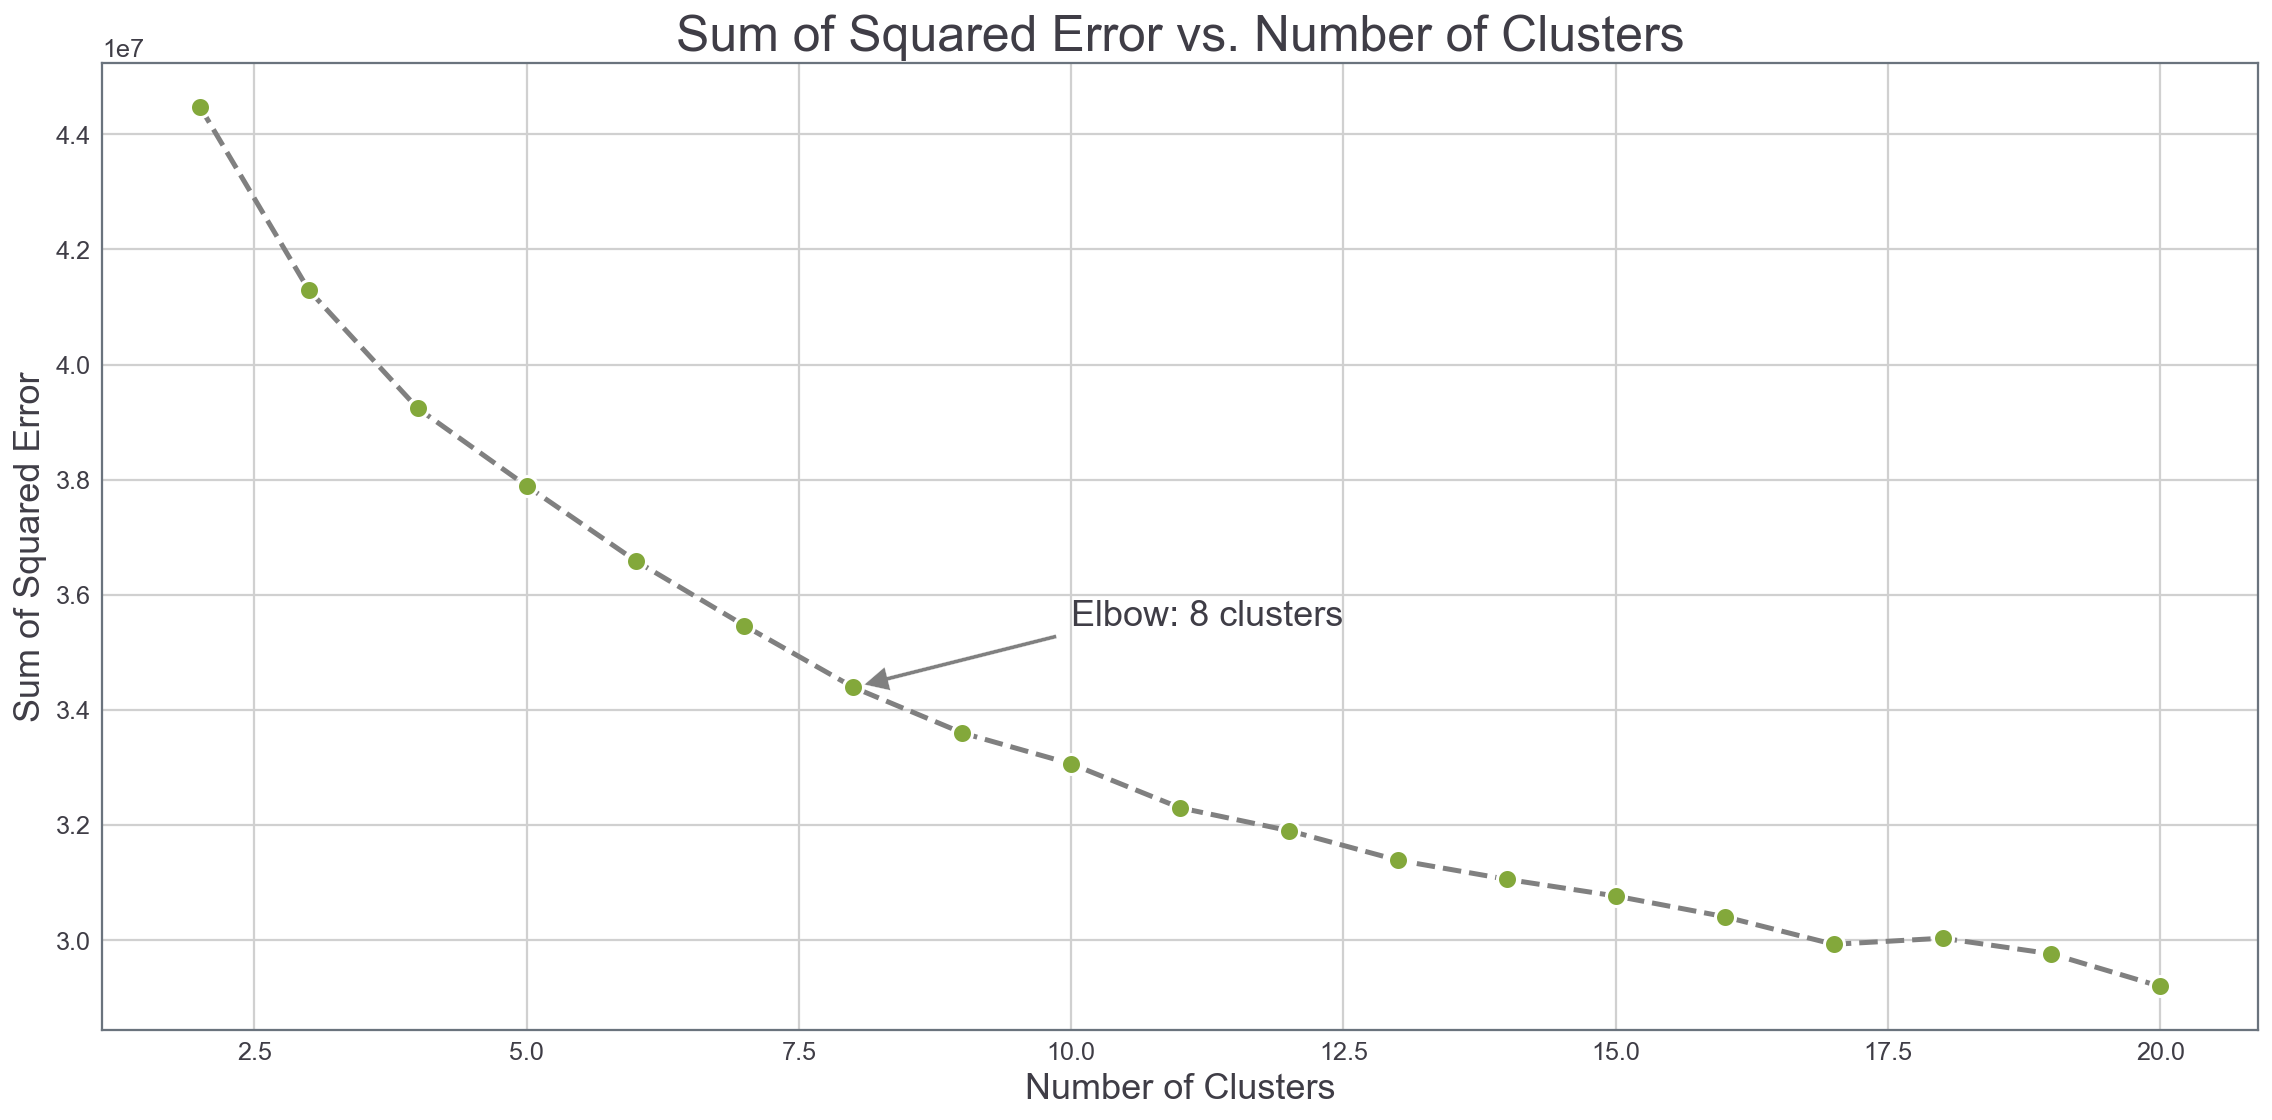

In [321]:
# plot reduction of SSE with incrementally increasing number of centroids

centroids = list(num_centroids)
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(
    centroids,
    results.values(),
    ls='--',
    marker='o',
    lw=2.5,
    ms=10,
    color='gray',
    mfc='g',
    mec='w',
    mew=1.5)
ax.annotate(
    'Elbow: 8 clusters',
    xy=(8, results[8]),
    arrowprops=dict(facecolor='gray', shrink=0.05, width=2),
    xytext=(10, results[7]),
    size=18)
ax.set_ylabel('Sum of Squared Error', fontdict={'fontsize': 18})
ax.set_xlabel('Number of Clusters', fontdict={'fontsize': 18})
ax.set_title(
    'Sum of Squared Error vs. Number of Clusters', fontdict={'fontsize': 25})
fig.tight_layout()

In [295]:
# ELBOW OBSERVED AT 8 CLUSTERS
clusters = 8
# refit model with chosen clusters
km = KMeans(n_clusters=clusters, random_state=41).fit(PCA_df)

In [296]:
print('Dimensions of clusters (clusters, components)',
      km.cluster_centers_.shape)

Dimensions of clusters (clusters, components) (8, 15)


In [297]:
print('Dimensions of labels', km.labels_.shape)

Dimensions of labels (780153,)


### Discussion 3.1: Apply Clustering to General Population

#### In the above SSE vs Number of Cluters curve, there isn't really a clear cut off of an elbow like in the lectures, but in the actual computation of the SSE for each k, I wrote a line of code to compare the SSE vs the previous iteration. The 8th iteration was the first time the SSE improved less than 3%, so this is why I decided to cut it off there, as the rest of the improvements were less than 1% after this and are not materially contributing to the model. 

### Step 3.2: Apply All Steps to the Customer Data

In [298]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [299]:
print('First five rows of customer data')
display(customers.head())

print('Descriptive Statistics')
display(customers.describe())

First five rows of customer data


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

Descriptive Statistics


AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  191652.000000         191652.000000  191652.000000  188439.000000   
mean        0.344359              3.060907       1.376432       3.677928   
std         1.391672              1.086254       0.484492       1.813975   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              3.000000       1.000000       2.000000   
50%         0.000000              3.000000       1.000000       4.000000   
75%         2.000000              4.000000       2.000000       6.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      191652.000000  191652.000000     191652.000000   191652.000000   
mean            3.963773       2.057051          4.183317        2.439808   
std             1.036230       1.319422          0.995365        1.697932   
min             1.000000       1.000000          1.000000        1.000000   
25%             3.000000       1.000000          3.000000        1.000000   
50%             4.000000       1.000000          5.000000        2.000000   
75%             5.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...           PLZ8_ANTG1  \
count          191652.000000     191652.000000      ...        138888.000000   
mean                2.646176          2.781176      ...             2.537404   
std                 1.586506          1.147353      ...             0.904927   
min                 1.000000          1.000000      ...             0.000000   
25%                 1.000000          2.000000      ...             2.000000   
50%                 2.000000          3.000000      ...             3.000000   
75%                 5.000000          3.000000      ...             3.000000   
max                 5.000000          5.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  138888.000000  138888.000000  138888.000000  138888.000000   
mean        2.731510       1.388817       0.539939       1.556607   
std         0.840922       0.885038       0.637048       1.185736   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       1.000000       0.000000       1.000000   
75%         3.000000       2.000000       1.000000       1.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  138888.000000  138888.000000  141176.000000  141176.000000   
mean        3.634893       3.622192       2.824850       5.119517   
std         0.933660       1.008472       1.012415       2.159184   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       2.000000       4.000000   
50%         3.000000       4.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

            RELAT_AB  
count  141176.000000  
mean        2.898510  
std         1.422683  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         9.000000  

[8 rows x 81 columns]

In [300]:
customers_cleaned, customers_cleaned_highNaN = clean_data(customers)

=> encoding missing values as NaN
=> removing columns selected
=> splitting into two datasets, one with high NaNs and one with low NaNs
=> re-encoding binary values and removing multi-level categorical columns
=> creating mixed features and removing other mixed feature columns
=> done!


In [301]:
# COMPARING CLEANED DATA RETURNED
print('CUSTOMER HIGH NaN')
print(customers_cleaned_highNaN['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(customers_cleaned_highNaN.shape)
print('--------------------------')
print('CUSTOMER CLEANED')
print(customers_cleaned['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(customers_cleaned.shape)
print('--------------------------')
print('CONTROL DATA (FULL DATA SET)')
print(cleaned['ALTERSKATEGORIE_GROB'].sort_values().unique())
print(cleaned.shape)

CUSTOMER HIGH NaN
[ 1.  2.  3.  4. nan]
(52584, 80)
--------------------------
CUSTOMER CLEANED
[ 1.  2.  3.  4. nan]
(139068, 64)
--------------------------
CONTROL DATA (FULL DATA SET)
[ 1.  2.  3.  4. nan]
(780153, 64)


In [302]:
display(customers_cleaned.describe())

ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         138856.000000  139068.000000      139068.000000  139068.000000   
mean               3.493130       1.330177           4.267891       1.423663   
std                0.724651       0.470278           1.017478       0.826490   
min                1.000000       1.000000           1.000000       1.000000   
25%                3.000000       1.000000           4.000000       1.000000   
50%                4.000000       1.000000           5.000000       1.000000   
75%                4.000000       2.000000           5.000000       2.000000   
max                4.000000       2.000000           5.000000       5.000000   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     139068.000000   139068.000000          139068.000000   
mean           4.570591        1.596945               1.845795   
std            0.838004        0.998658               0.964908   
min            1.000000        1.000000               1.000000   
25%            4.000000        1.000000               1.000000   
50%            5.000000        1.000000               2.000000   
75%            5.000000        2.000000               2.000000   
max            5.000000        5.000000               5.000000   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP      ...        \
count     139068.000000     139068.000000  136957.000000      ...         
mean           2.742939          0.501625       1.966004      ...         
std            1.314828          0.499999       0.772332      ...         
min            1.000000          0.000000       1.000000      ...         
25%            2.000000          0.000000       1.000000      ...         
50%            2.000000          1.000000       2.000000      ...         
75%            4.000000          1.000000       3.000000      ...         
max            5.000000          1.000000       3.000000      ...         

          PLZ8_ANTG4       PLZ8_HHZ       PLZ8_GBZ         ARBEIT  \
count  138263.000000  138263.000000  138263.000000  138526.000000   
mean        0.540108       3.634870       3.621663       2.826047   
std         0.637266       0.933392       1.008625       1.008956   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       3.000000       3.000000       2.000000   
50%         0.000000       3.000000       4.000000       3.000000   
75%         1.000000       4.000000       4.000000       4.000000   
max         2.000000       5.000000       5.000000       5.000000   

         ORTSGR_KLS9       RELAT_AB         DECADE       MOVEMENT  \
count  138547.000000  138526.000000  138033.000000  138033.000000   
mean        5.121417       2.899297       2.877073       1.505386   
std         2.159498       1.420624       1.340492       0.499973   
min         1.000000       1.000000       1.000000       1.000000   
25%         4.000000       2.000000       2.000000       1.000000   
50%         5.000000       3.000000       3.000000       2.000000   
75%         7.000000       4.000000       4.000000       2.000000   
max         9.000000       5.000000       6.000000       2.000000   

              WEALTH     LIFE_STAGE  
count  138792.000000  138792.000000  
mean        2.597289       3.370403  
std         1.406275       1.339537  
min         1.000000       1.000000  
25%         1.000000       2.000000  
50%         2.000000       4.000000  
75%         4.000000       4.000000  
max         5.000000       5.000000  

[8 rows x 64 columns]

In [303]:
# fitting the scaler object on data with NaNs removed to not skew results
cust_cleaned_dropped_NaN = customers_cleaned.dropna(
    axis=0)  # defaults to dropping rows with at least one NaN

print(cust_cleaned_dropped_NaN.shape)  # fit to cleaned dropped NaN data

(115643, 64)


In [304]:
# imputing missing values using each column's respective mean

cust_imputed = imputer_obj.transform(
    customers_cleaned)  # fit to cleaned data with NaNs (no labels)

# RETURNS A NUMPY ARRAY
print('Customer Imputed type: {}'.format(type(cust_imputed)))
print('Customer Imputed shape: {}'.format(cust_imputed.shape))

Customer Imputed type: <class 'numpy.ndarray'>
Customer Imputed shape: (139068, 64)


In [305]:
# still need to transform the imputed data with the scaler that was fit above

cust_imputed_scaled = scaler.transform(cust_imputed)
print('Customer Imputed_scaled type: {}'.format(type(cust_imputed_scaled)))
print('Customer Imputed_scaled shape: {}'.format(cust_imputed_scaled.shape))

Customer Imputed_scaled type: <class 'numpy.ndarray'>
Customer Imputed_scaled shape: (139068, 64)


In [306]:
# convert scaled and imputed data back into a pandas DF
cust_clean_scaled = pd.DataFrame(
    cust_imputed_scaled, columns=customers_cleaned.columns)
cust_cleaned_scaled_NaNs = cust_clean_scaled.isnull().sum().sum()

print('Scaled customer data shape: {}'.format(cust_clean_scaled.shape))
print('-' * 40)
print('{} NaNs after imputation and scaling! :)'.format(
    cust_cleaned_scaled_NaNs))
print('')
print('Let\'s look at how the data looks now')
print('-' * 40)
display(cust_clean_scaled.describe())

Scaled customer data shape: (139068, 64)
----------------------------------------
0 NaNs after imputation and scaling! :)

Let's look at how the data looks now
----------------------------------------


ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         139068.000000  139068.000000      139068.000000  139068.000000   
mean               0.681481      -0.362159           0.889266      -0.853046   
std                0.705910       0.940793           0.747720       0.562521   
min               -1.746287      -1.022678          -1.512226      -1.141397   
25%                0.202108      -1.022678           0.692400      -1.141397   
50%                1.176305      -1.022678           1.427276      -1.141397   
75%                1.176305       0.977825           1.427276      -0.460783   
max                1.176305       0.977825           1.427276       1.581061   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     139068.000000   139068.000000          139068.000000   
mean           0.805803       -0.809823              -0.522695   
std            0.603370        0.689302               0.703129   
min           -1.765054       -1.221852              -1.139026   
25%            0.394972       -1.221852              -1.139026   
50%            1.114980       -1.221852              -0.410325   
75%            1.114980       -0.531624              -0.410325   
max            1.114980        1.539061               1.775776   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP      ...        \
count     139068.000000     139068.000000  139068.000000      ...         
mean          -0.312458          0.630062      -0.313547      ...         
std            0.962905          1.179896       1.011012      ...         
min           -1.588887         -0.553672      -1.591635      ...         
25%           -0.856544         -0.553672      -1.591635      ...         
50%           -0.856544          1.806125      -0.273495      ...         
75%            0.608142          1.806125       1.044646      ...         
max            1.340485          1.806125       1.044646      ...         

          PLZ8_ANTG4       PLZ8_HHZ       PLZ8_GBZ         ARBEIT  \
count  139068.000000  139068.000000  139068.000000  139068.000000   
mean       -0.242574       0.020845       0.242359      -0.375656   
std         0.868550       0.968522       0.903473       1.018220   
min        -0.981973      -2.721004      -2.111170      -2.223015   
25%        -0.981973      -0.639701      -0.314765      -1.212095   
50%        -0.981973      -0.001920       0.583438      -0.201175   
75%         0.384671       0.400951       0.583438       0.809745   
max         1.751315       1.441603       1.481641       1.820665   

         ORTSGR_KLS9       RELAT_AB         DECADE       MOVEMENT  \
count  139068.000000  139068.000000  139068.000000  139068.000000   
mean       -0.118652      -0.157706      -0.979591       0.634063   
std         0.938913       1.049460       0.924034       1.176783   
min        -1.914219      -1.563993      -2.280170      -0.553672   
25%        -0.607437      -0.823841      -1.591245      -0.553672   
50%        -0.171843      -0.083688      -0.902320       1.806125   
75%         0.699344       0.656464      -0.213395       1.806125   
max         1.570532       1.396616       1.164455       1.806125   

              WEALTH     LIFE_STAGE  
count  139068.000000  139068.000000  
mean       -0.499355       0.329232  
std         0.963911       0.892676  
min        -1.595951      -1.251111  
25%        -1.595951      -0.584134  
50%        -0.909992       0.749820  
75%         0.461926       0.749820  
max         1.147884       1.416797  

[8 rows x 64 columns]

In [307]:
cust_pca_obj = pca_obj_15.transform(cust_clean_scaled)
display(cust_pca_obj.shape)

(139068, 15)

In [308]:
cust_pca_df = pd.DataFrame(cust_pca_obj)
display(cust_pca_df.describe())

0              1              2              3   \
count  139068.000000  139068.000000  139068.000000  139068.000000   
mean       -2.346124       1.402227       1.470411       0.932986   
std         2.737534       2.170620       2.204767       2.008548   
min        -7.889649      -7.580626      -4.733645      -5.525158   
25%        -4.425242       0.104446      -0.760591      -0.689304   
50%        -3.081858       1.381313       2.207108       0.949332   
75%        -0.711460       2.806023       3.250452       2.572760   
max        11.556666      10.814509       6.363463       9.423715   

                  4              5              6              7   \
count  139068.000000  139068.000000  139068.000000  139068.000000   
mean       -0.023586      -0.033337       0.098884       0.010763   
std         1.536119       1.528197       1.458367       1.415119   
min        -6.113873      -5.081866      -3.508358      -5.712897   
25%        -0.898418      -1.111474      -0.698630      -0.985826   
50%        -0.242774      -0.192788       0.002272       0.039350   
75%         0.466308       0.917354       0.703291       1.009688   
max        10.654279       8.687074      36.855561       7.778966   

                  8              9              10             11  \
count  139068.000000  139068.000000  139068.000000  139068.000000   
mean        0.168724       0.330049       0.338282       0.016379   
std         1.238587       1.058535       1.097925       1.177876   
min        -5.368345      -4.587404      -4.311134      -4.779633   
25%        -0.671596      -0.390183      -0.390548      -0.764095   
50%         0.128119       0.351151       0.351481       0.094853   
75%         0.979708       1.061817       1.083134       0.801301   
max         7.251538       5.560760       5.061560      13.881275   

                  12             13             14  
count  139068.000000  139068.000000  139068.000000  
mean        0.156170      -0.035669      -0.029527  
std         1.976680       0.970779       0.973406  
min        -2.489786      -6.657165      -3.868352  
25%        -0.477678      -0.647523      -0.686664  
50%        -0.098579      -0.028369      -0.029575  
75%         0.284632       0.598551       0.622253  
max        69.953576       4.156102       9.022996

In [309]:
cust_kmeans = km.predict(cust_pca_obj)

In [310]:
display(pd.Series(cust_kmeans).value_counts())

3    68460
4    25953
7    17651
0    14676
5     5626
1     2561
6     2483
2     1658
dtype: int64

In [311]:
display(cust_kmeans.shape)

(139068,)

### Step 3.3: Compare Customer Data to Demographics Data

In [312]:
# GENERAL POPULATION
gen_centr_labels = km.labels_  # population dataset labels from kmeans object

# add back NaN from earlier as a cluter of its own with label -1
gen_centr_labels_NaN = np.append(gen_centr_labels, [-1] * test_high.shape[0])

# value counts for each centroid
gen_centr_value_counts = np.unique(gen_centr_labels_NaN, return_counts=True)
gen_centr_value_counts = np.array(
    [[x, y]
     for x, y in zip(gen_centr_value_counts[0], gen_centr_value_counts[1])])

# proportion of data associated with each centroid
gen_centr_prop = gen_centr_value_counts[:, 1] / gen_centr_value_counts[:,1].sum()

# combine the value counts and the proportion of each cluster
gen_centr_freq = (np.array(
    [[x, y, z]
     for x, y, z in zip(gen_centr_value_counts[:, 0],
                        gen_centr_value_counts[:, 1], gen_centr_prop)]))

##############################################################################
# CUSTOMER DATA SET

# labels/predictions created above
cust_centr_labels = cust_kmeans

# add back NaN from earlier as a cluter of its own with label -1
cust_centr_labels_NaN = (np.append(cust_centr_labels,
                                   [-1] * customers_cleaned_highNaN.shape[0]))
# value counts for each centroid
cust_centr_value_counts = np.unique(cust_centr_labels_NaN, return_counts=True)
cust_centr_value_counts = np.array(
    [[x, y]
     for x, y in zip(cust_centr_value_counts[0], cust_centr_value_counts[1])])

# proportion of data associated with each centroid
cust_centr_prop = (
    cust_centr_value_counts[:, 1] / cust_centr_value_counts[:, 1].sum())

# combine the value counts and the proportion of each cluster
cust_centr_freq = (np.array(
    [[x, y, z]
     for x, y, z in zip(cust_centr_value_counts[:, 0],
                        cust_centr_value_counts[:, 1], cust_centr_prop)]))

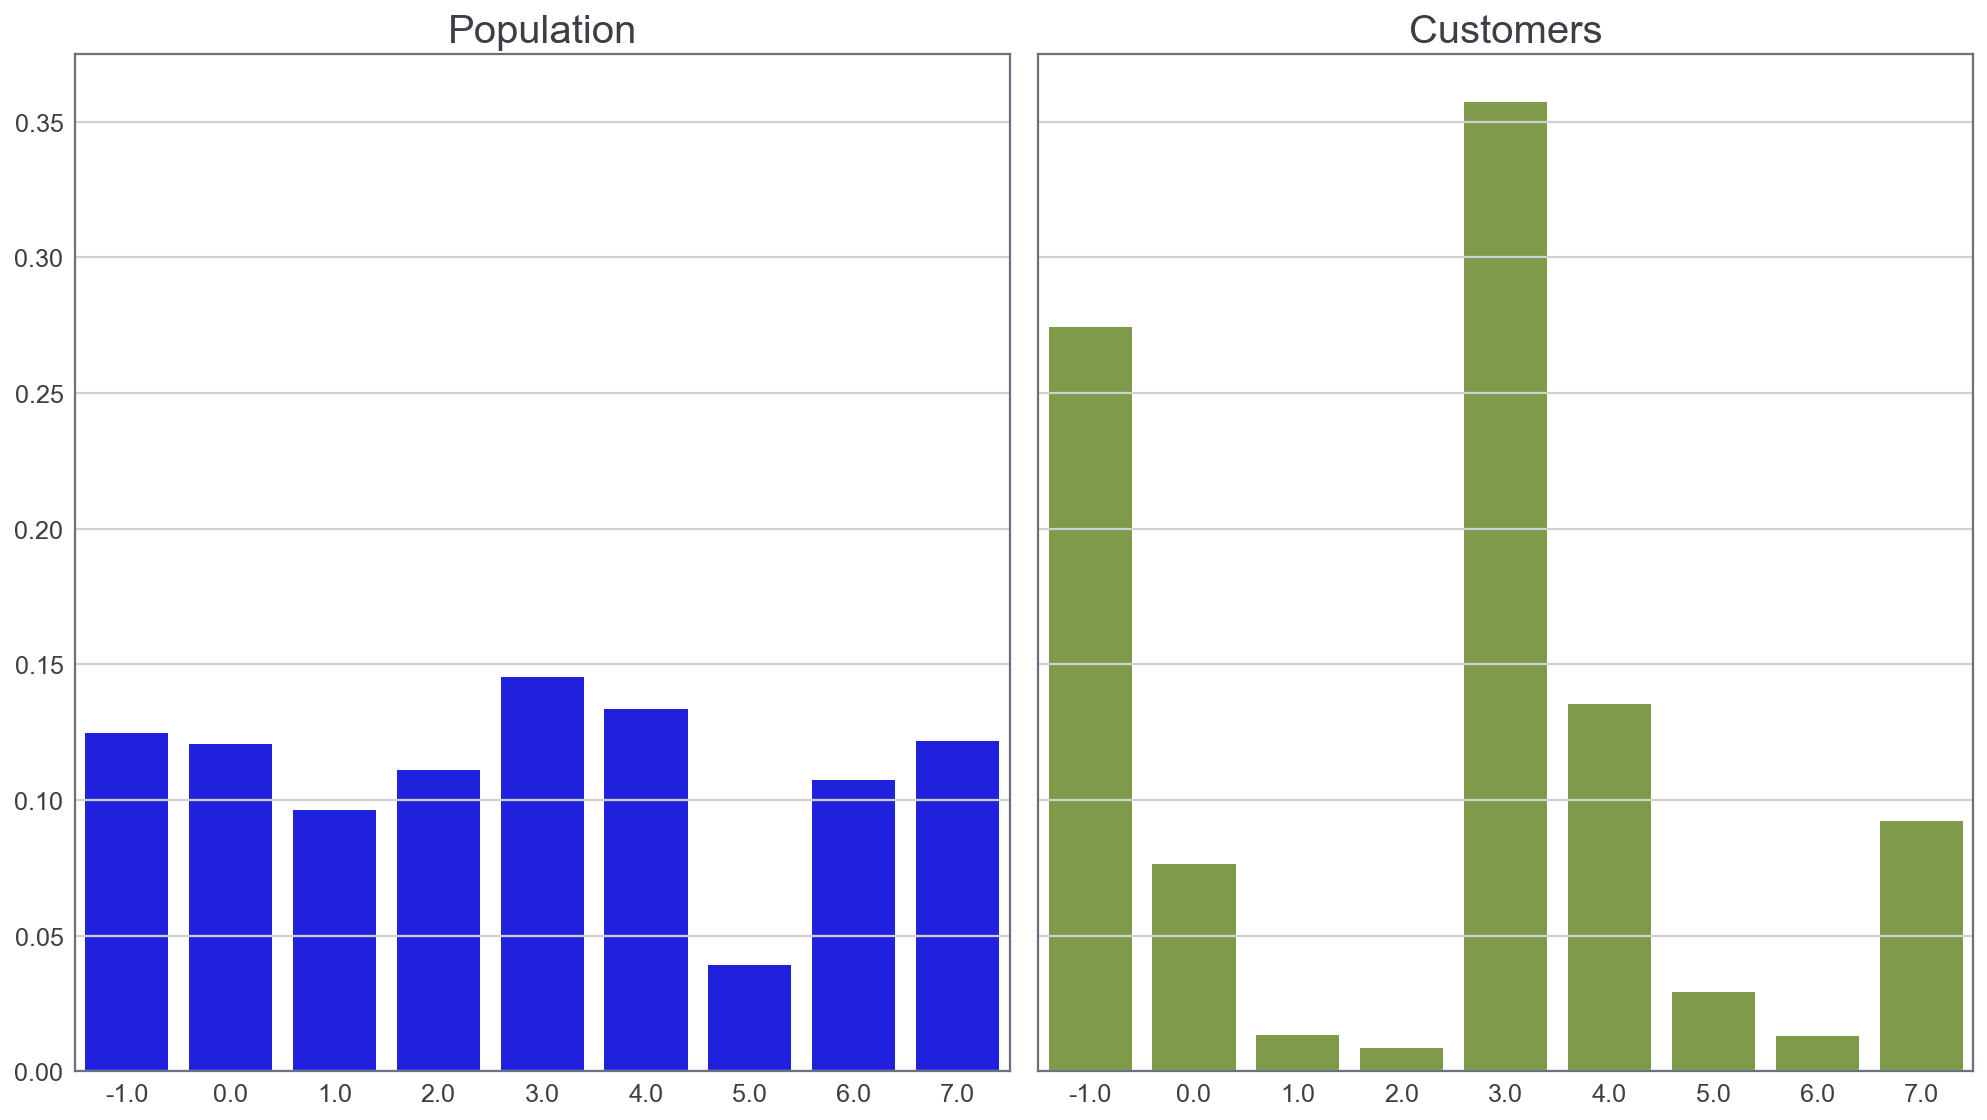

In [313]:
# comparing the two datasets to see how evenly they are distributed

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
sns.barplot(
    x=gen_centr_freq[:, 0], y=gen_centr_freq[:, 2], color='blue', ax=axes[0])
sns.barplot(
    x=cust_centr_freq[:, 0], y=cust_centr_freq[:, 2], color='g', ax=axes[1])
axes[0].set_title('Population', fontdict={'fontsize': 20})
axes[1].set_title('Customers', fontdict={'fontsize': 20})
fig.tight_layout()

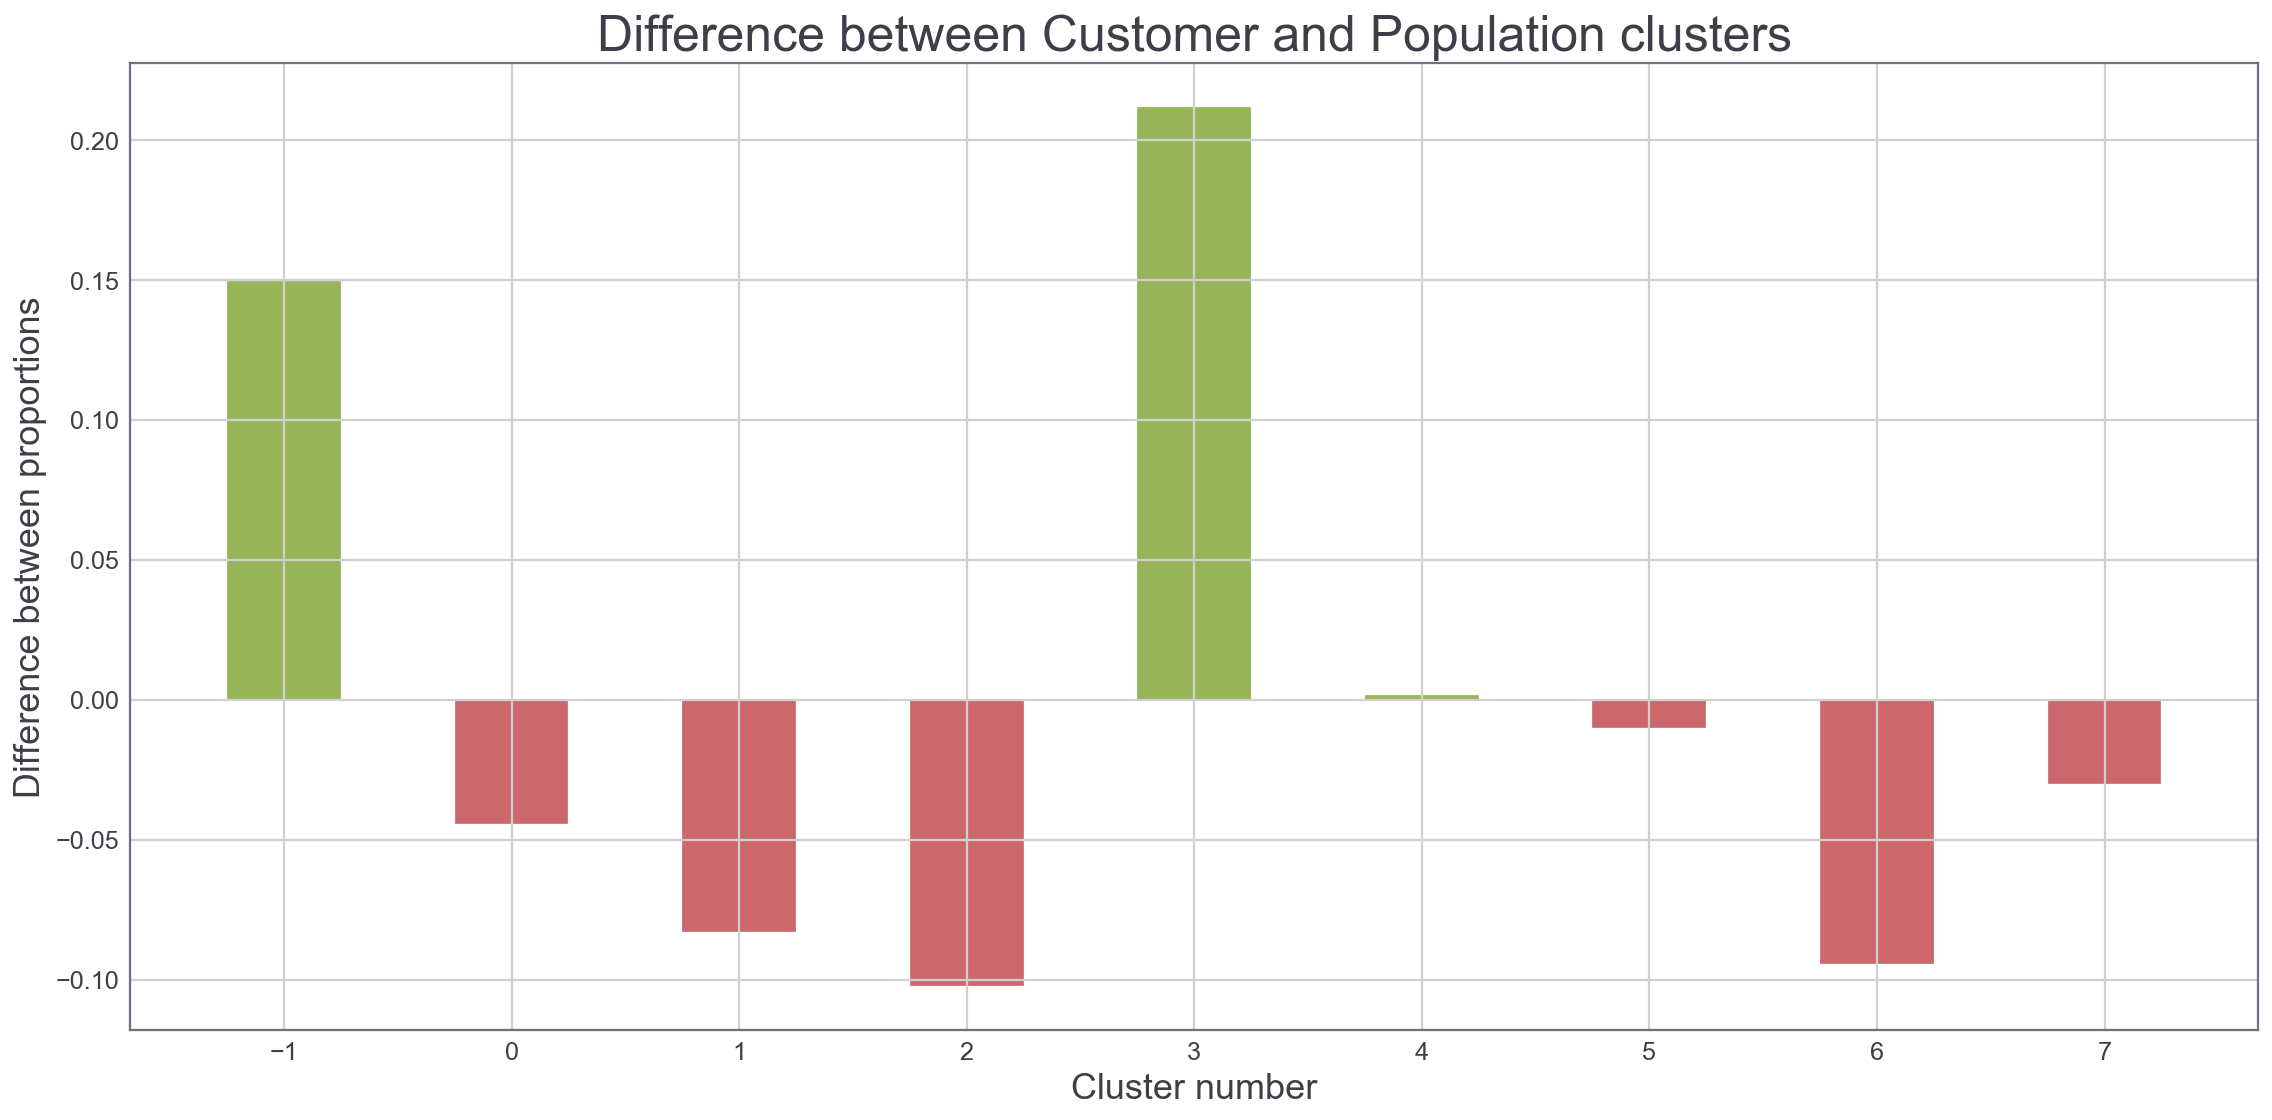

In [314]:
# Calculate the differences between the two datasets
diff_prop = cust_centr_freq[:, 2] - gen_centr_freq[:, 2]
pos_diff = pd.Series(diff_prop > 0)  # boolean array for conditional plotting
# plot the differences for visual inference
fig, ax = plt.subplots(figsize=(16, 8))
i = cust_centr_freq[:, 0]
wid = 0.50
op = 0.85

ax.bar(
    i,
    diff_prop,
    wid,
    alpha=op,
    color=pos_diff.map({
        True: 'g',
        False: 'r'
    }),
    edgecolor='w')
ax.set_xticks(i)
ax.set_title(
    'Difference between Customer and Population clusters',
    fontdict={'fontsize': 25})
ax.set_xlabel('Cluster number', fontdict={'fontsize': 18})
ax.set_ylabel('Difference between proportions', fontdict={'fontsize': 18})
fig.tight_layout()

#### A few quick observations:
- Cluster 3 above is definitely the outlier here, as it is clearly over-represented in the customer data when compared to the demographic data. Clusters 1, 2, and 6 are underrepresented, conversely. The NaN cluster is a bit disconcerting; the overrepresentation of the NaN proportion in comparison to the general population means there is a great deal more NaNs in the customer dataset when compared to the general population. This is something that should be considered when concluding the analysis and drawing insights.

In [315]:
# we need to add the cluster predictions to the customer dataframe to look at the clusters
cust_pca_df['CENTROID'] = cust_kmeans
cust_pca_df.rename(
    columns={
        0: 'FinancialStand-PopDensity',
        1: 'Gen-BuyingHabits-Age',
        2: 'Gender-Personality'
    },
    inplace=True)

In [316]:
# adapt earlier function to work with kmeans object
def map_weight_feats_kmeans(kmeans, df, centr):
    '''
    INPUT: 
        kmeans - Fit KMeans object
        df - DataFrame with full data
        centr - integer of centroid/cluster index
    OUTPUT: 
        positive_comp - pandas series with positive weights
        negative_comp - pandas series with negative weights
    '''
    # dataframe with cluster weights
    w = pd.DataFrame(np.round(kmeans.cluster_centers_, 6), columns=df.keys())
    # grab cluster of interest by index
    clust = w.iloc[centr, :]
    # sort weights into neg/pos dataframes
    positive_clust = clust[clust > 0].sort_values(ascending=False)
    negative_clust = clust[clust < 0].sort_values(ascending=True)

    return positive_clust, negative_clust

In [317]:
pos_clust_over, neg_clust_over = map_weight_feats_kmeans(
    km, cust_pca_df.drop('CENTROID', axis=1), 3)

print('*' * 40)
print('Positive weights for cluster 3')
print('*' * 40)
print(pos_clust_over.head())
print('*' * 40)
print('Negative weights for cluster 3')
print('*' * 40)
print(neg_clust_over.head())
print('*' * 40)

****************************************
Positive weights for cluster 3
****************************************
Gender-Personality    2.202869
7                     0.179779
3                     0.132061
13                    0.117841
14                    0.089217
Name: 3, dtype: float64
****************************************
Negative weights for cluster 3
****************************************
FinancialStand-PopDensity   -3.293342
4                           -0.418961
5                           -0.310855
11                          -0.183892
8                           -0.118273
Name: 3, dtype: float64
****************************************


In [318]:
pos_clust_under, neg_clust_under = map_weight_feats_kmeans(
    km, cust_pca_df.drop('CENTROID', axis=1), 2)

print('*' * 40)
print('Positive weights for cluster 2')
print('*' * 40)
print(pos_clust_under.head())
print('*' * 40)
print('Negative weights for cluster 2')
print('*' * 40)
print(neg_clust_under.head())
print('*' * 40)

****************************************
Positive weights for cluster 2
****************************************
FinancialStand-PopDensity    4.974833
6                            0.323776
3                            0.260409
9                            0.256906
4                            0.206524
Name: 2, dtype: float64
****************************************
Negative weights for cluster 2
****************************************
Gen-BuyingHabits-Age   -1.426123
Gender-Personality     -0.956512
5                      -0.205985
12                     -0.184092
8                      -0.113774
Name: 2, dtype: float64
****************************************


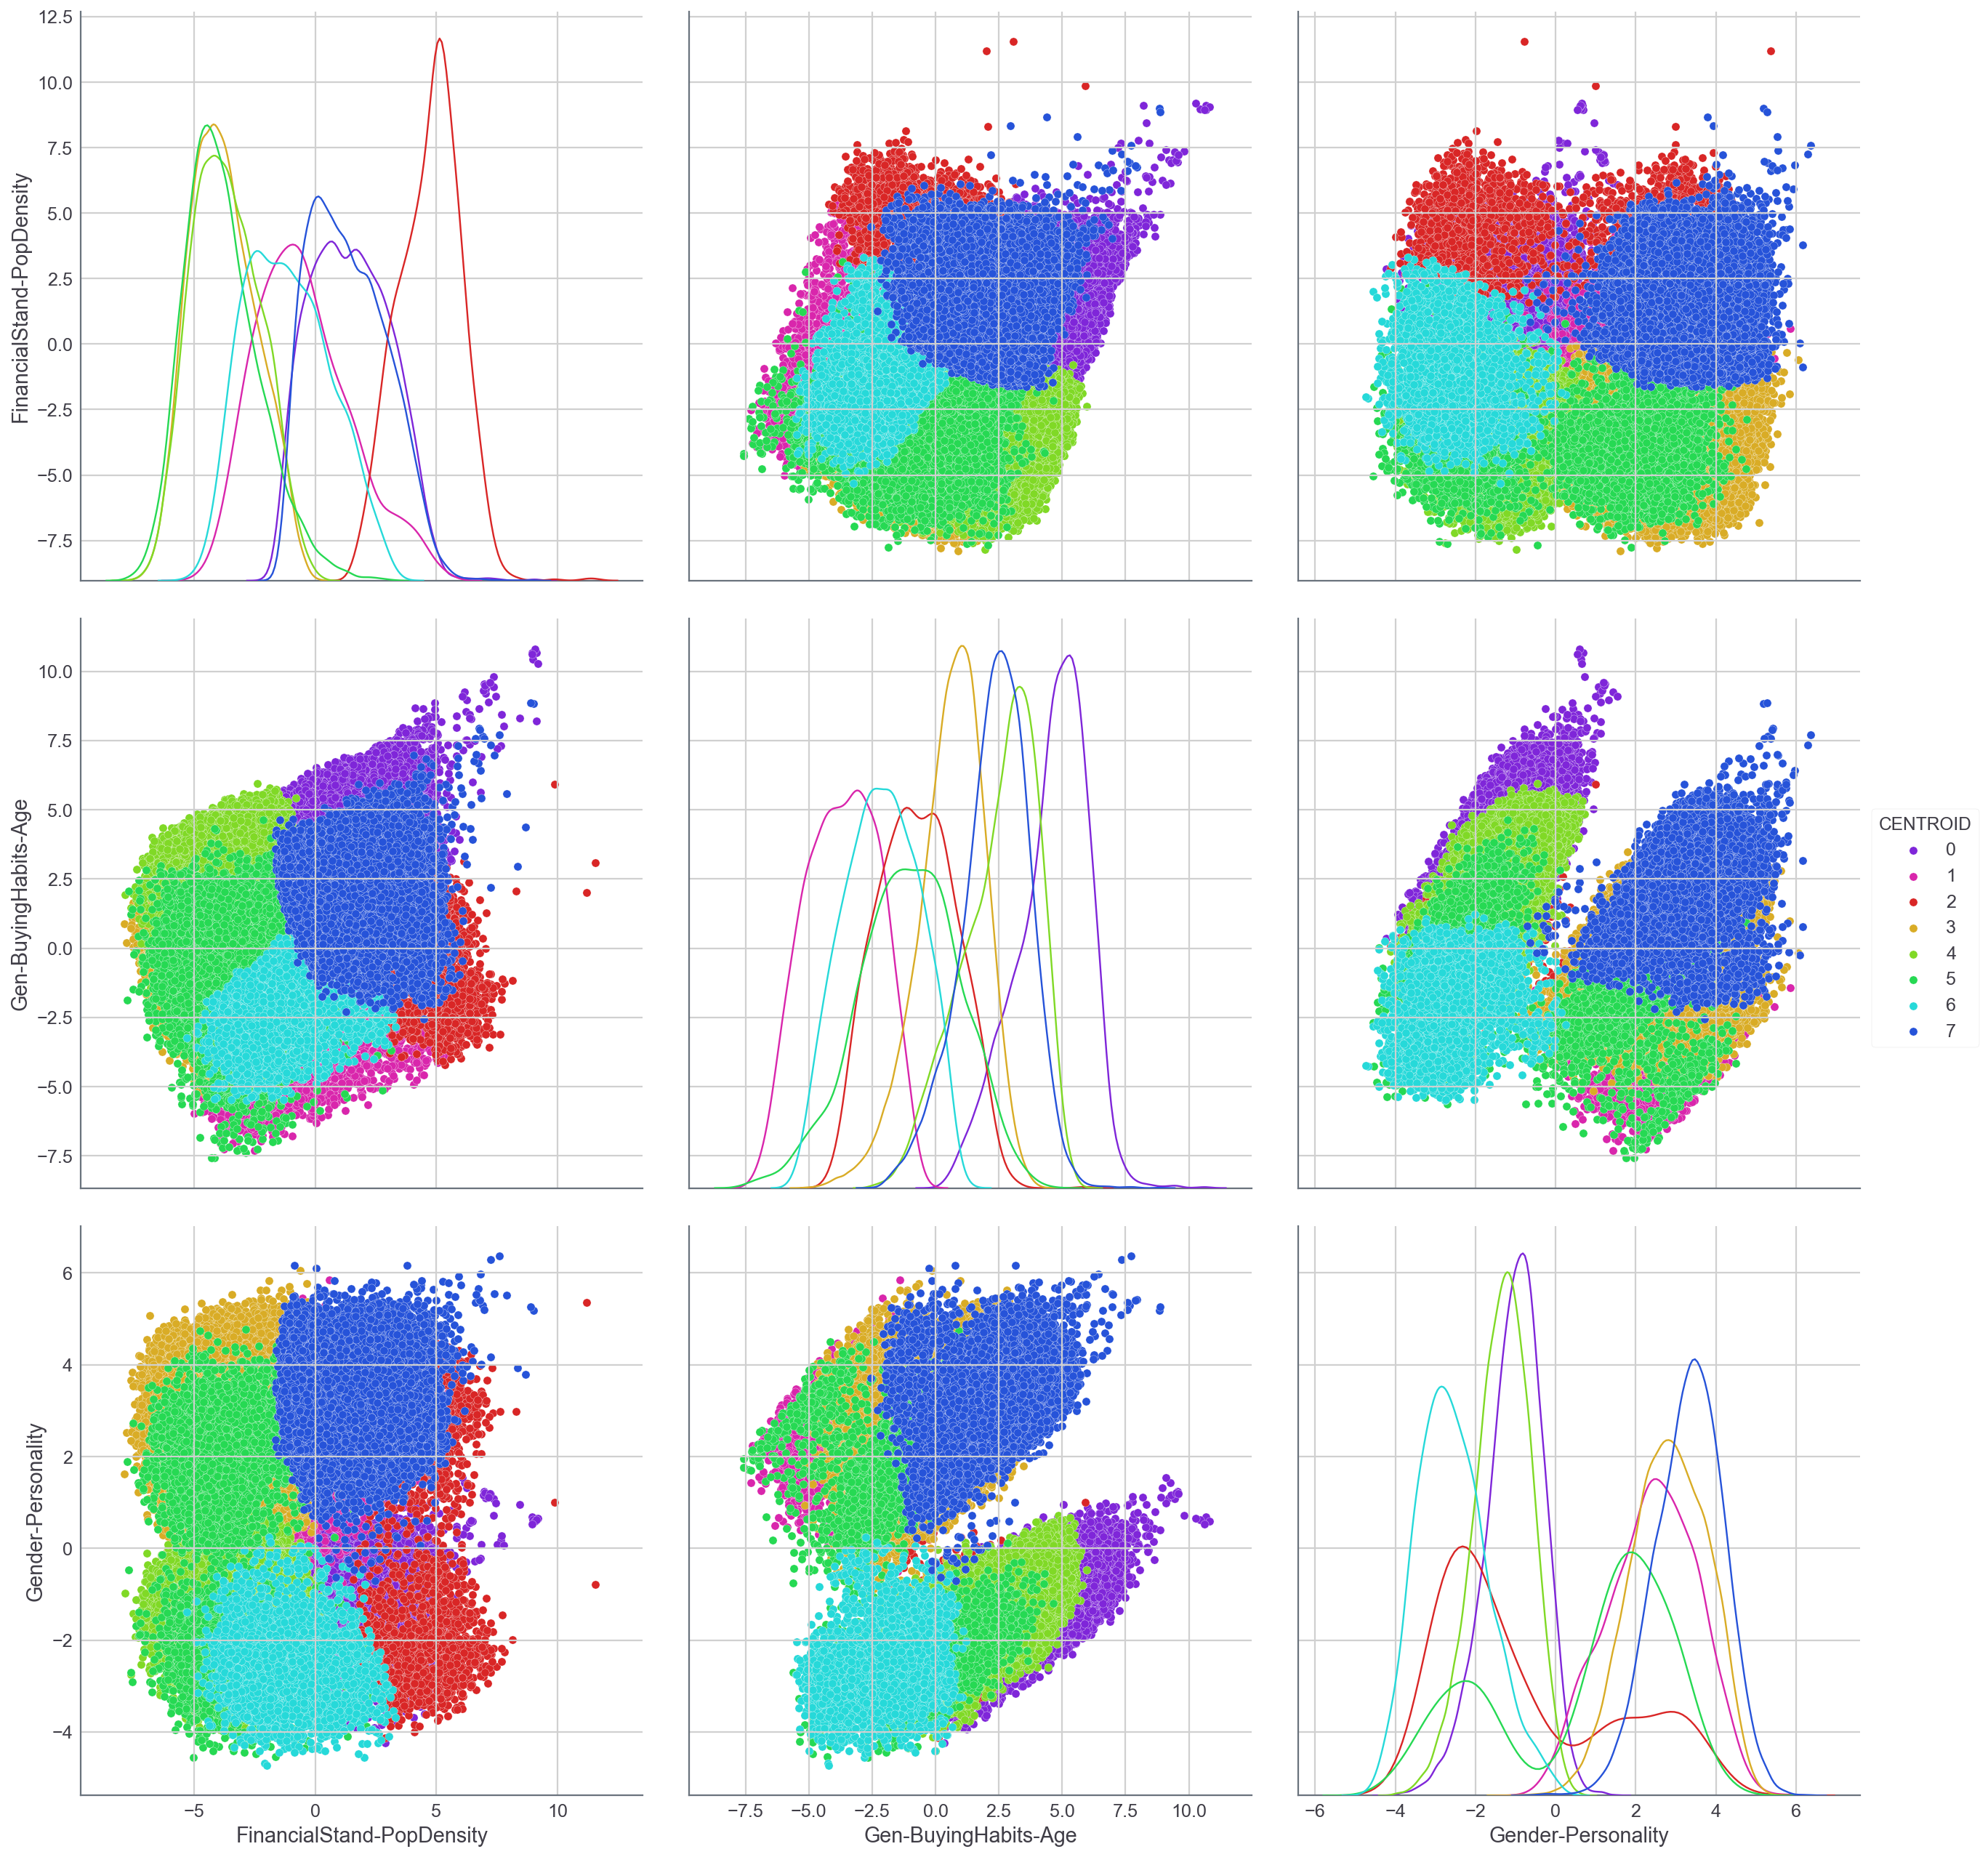

In [319]:
# pairplot of different clusters and their values for the
# top three principal components
p = sns.pairplot(
    cust_pca_df,
    vars=[
        'FinancialStand-PopDensity', 'Gen-BuyingHabits-Age',
        'Gender-Personality'
    ],
    diag_kind='kde',
    hue="CENTROID",
    size=6,
    palette=sns.hls_palette(8, l=.50, h=6 / 8, s=.70))

# Summary
- In the _Difference between Population and Customer clusters_ graph, you can see that cluster three clearly over-represented in the customer data when compared to the demographic data. Clusters 1, 2, and 6 are underrepresented, conversely (cluster 2 moreso than the others). From our initial analysis of the first three principal components we surmised that the 0th component encapsulated the financial standing, and population density of an individual. The 1st component encapsulated the individual's generation, their buying habits, and their age. The 2nd component captured their gender, and their major personality traits. 

- In the above pairplot of the first three components, all points are segmented into their respective clusters/centroids. 
### - Cluster #3 (yellow) is the cluster we deemed overrepresented above. If you analyse across the horizontal axes by each principal component you will see that:
    - The values for the 0th component (`FinancialStand-PopDensity`) are lower, the values for the 1st component (`Gen-BuyingHabits-Age`) are ambivalent/undiscernably positive/negative, and the 2nd component (`Gender-Personality`) has values well above zero. 
    - If we look into the most positive/negative weights for each cluster, we see that `Gender-Personality` is very high, as is `FinancialStand-PopDensity`. Remember, during the breakdown of the composition of the initial components, we observed that 
        - *"The gender inference here is very important; there is a large negative weight with gender, `ANREDE_KZ` which means we can infer the positive traits belong to men as the negative indicates female gender. Specifically, that men are less dreamful, less socially-minded, less family-minded, less culturally-minded, and are not financial minimialists"*
    - Consequently, we can infer here that the over-represented cluster belongs to men that are not financially prepared, not event-driven, determined minimal-returner, less-dreamful, and are on the older side/evenly distributed. This segment of the population is therefore central to the sales company's customer base.
    
### - Cluster #2 (red) is the cluster we deemed underrepresented above. If you analyse across the horizontal axes by each principal compenent you will see that:
- The values for the 0th component (`FinancialStand-PopDensity`) are much higher than compared to cluster #3, and the values for the 1st component `Gen-BuyingHabits-Age` are very negative. We can observe, therefore, that the underrepresented cluster/group are:
    - Women on the younger side (as the gender score is opposite of cluster #3 which is Men) who have low-religious affinity, associate themselves with the younger side of the decade of youth, are money savers, have low financial insconspicuousity, are less-rational, are less critical-minded, are less dominantly-minded, are less combatitive, and are more traditionally minded. This segment of the population therefore is not central to the sales company's customer base.

